## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart as waterfall
from operator import attrgetter
from scipy.stats import normaltest
import missingno


pd.options.display.max_columns = None

# Ecommerce Evaluation
By Muhammad Zulfikar Muslim

## 1. Introduction

**Context**

Sebagai seorang Data Analis yang bekerja untuk perusahaan eCommerce bernama D&E Co, kita harus menyiapkan presentasi untuk Head of Sales dan Head of Operations yang merangkum kinerja penjualan dan operasi.

**Problem Statement**

Presentasi tersebut paling sedikit terdiri dari :
- Gambaran singkat tentang kondisi bisnis saat ini
- Informasi kepuasan pelanggan saat ini
- Proposal terkait 2-3 area yang dapat dikembangkan oleh perusahaan

**Scope of Problem**
- Saat ini adalah bulan September 2018 (kita dapat mengabaikan seluruh data setelah September 2018)
- Awal perusahan di bulan Januari 2017 (kita dapat mengabaikan seluruh data sebelum Januari 2017)
- Perusahaan berbasis di US tetapi diluncurkan di Brazil (itulah sebabnya beberapa informasi dalam bahasa Portugis)
- Kita dapat menganggap semua pesanan telah terkirim (jadi abaikan 'order_status')


## 2. Data Preparation

Dalam studi ini, kita akan menggunakan data eCommerce yang bersumber dari https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce.

Dataset terdiri dari 7 file csv yang memiliki kaitan satu sama lain, yaitu :

- Orders dataset: Menyediakan informasi mengenai barang yang dipesan.
- Order items dataset: Informasi mengenai barang yang dipesan untuk masing masing order dan biaya pengiriman serta harga untuk setiap barang. 
- Order payments dataset: Menyediakan informasi terkait pembayaran untuk setiap pesanan.
- Product dataset: Menyediakan informasi terkait produk.
- Product category name translated dataset: Berisi informasi terjemahan nama kategori dari bahasa Portugis ke Inggris
- Order reviews dataset: Berisi informasi review untuk setiap pesanan.
- Customers dataset: Dateset ini berisi informasi terkait customer_id, dimana terhubung langsung pada order_id di dataset orders. 


### 2.1 Data Descriptions

Berikut disampaikan deskripsi singkat terkait fitur-fitur yang terdapat pada dataset.

**olist_customers_dataset.csv**

| Feature | Description |
| --- | --- | 
|customer_id |Key to the orders dataset. Each order has a unique customer_id |
|customer_unique_id |Unique identifier of a customer |
|customer_zip_code_prefix |First 5 digits of customer zip code |
|customer_city |Customer city name |
|customer_state |Customer state |

**olist_order_items_dataset.csv**

| Feature | Description |
| --- | --- | 
|order_id |Order unique identifier |
|order_item_id |Sequential number identifying number of items included in the same order |
|product_id |Product unique identifier |
|seller_id |Seller unique identifier |
|shipping_limit_date |Shows the seller shipping limit date for handling the order over to the logistic partner |
|price |Item price |
|freight_value |Item freight value |

**olist_order_payments_dataset.csv**

| Feature | Description |
| --- | --- | 
|order_id |Unique identifier of an order |
|payment_sequential |A customer may pay an order with more than one payment method |
|payment_type |Method of payment chosen by the customer |
|payment_installments |Number of installments chosen by the customer |
|payment_value |Transaction value |

**olist_order_reviews_dataset.csv**

| Feature | Description |
| --- | --- | 
|review_id |Unique review identifier |
|order_id |Unique order identifier |
|review_score |Note ranging from 1 to 5 given by the customer on a satisfaction survey |
|review_comment_title |Comment title from the review left by the customer, in Portuguese |
|review_comment_message |Comment message from the review left by the customer, in Portuguese |
|review_creation_date |Shows the date in which the satisfaction survey was sent to the customer |
|review_answer_timestamp |Shows satisfaction survey answer timestamp |

**olist_orders_dataset.csv**

| Feature | Description |
| --- | --- | 
|order_id |Unique identifier of the order |
|customer_id |Key to the customer dataset. Each order has a unique customer_id |
|order_status |Reference to the order status |
|order_purchase_timestamp |Shows the purchase timestamp |
|order_approved_at |Shows the payment approval timestamp |
|order_delivered_carrier_date |Shows the order posting timestamp. When it was handled to the logistic partner |
|order_delivered_customer_date |Shows the actual order delivery date to the customer |
|order_estimated_delivery_date |Shows the estimated delivery date that was informed to customer at the purchase moment |

**olist_products_dataset.csv**

| Feature | Description |
| --- | --- | 
|product_id |Unique product identifier |
|product_category_name |Root category of product, in Portuguese |
|product_name_lenght |Number of characters extracted from the product name |
|product_description_lenght |Number of characters extracted from the product description |
|product_photos_qty |Number of product published photos |
|product_weight_g |Product weight measured in grams |
|product_length_cm |Product length measured in centimeters |
|product_height_cm |Product height measured in centimeters |
|product_width_cm |Product width measured in centimeters |

**product_category_name_translation.csv**

| Feature | Description |
| --- | --- | 
|product_category_name |Category name in Portuguese |
|product_category_name_english |Category name in English |

### 2.2 Reading the Datasets

Pertama-tama kita akan membaca dataset dari file csv yang telah kita download. 

Kita akan memasukkan parameter parse_dates pada fungsi read_csv() untuk membaca kolom yang berupa datetime.

In [2]:
# Import Datasets

customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv", parse_dates=['shipping_limit_date'])
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv", parse_dates=['review_creation_date','review_answer_timestamp'])
orders = pd.read_csv("olist_orders_dataset.csv", parse_dates=['order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'])
products = pd.read_csv("olist_products_dataset.csv")
products_category_translation = pd.read_csv("product_category_name_translation.csv")

### 2.3 Understanding the Datasets
Untuk mendapatkan gambaran isi dari tiap-tiap dataset, maka kita akan coba tampilkan informasi kolom, jumlah unique value, beserta statistik singkat pada masing-masing dataset.

In [3]:
# Fungsi untuk menampilkan kolom dan jumlah unique value pada tiap kolom

def table_summary(df) :

    list_item = []

    # menghitung jumlah null untuk tiap kolom
    list_no_null = list(df.isna().sum())
    
    # membuat dataframe yang berisi informasi nama kolom, jumlah unique value, dan contoh unique value
    for col in df.columns :
        list_item.append( [col, df[col].nunique(), df[col].unique()])
    unique_df = pd.DataFrame(columns=['column name', 'number of unique', 'unique sample'],
                        data=list_item)

    # membuat dataframe yang berisi informasi statistik
    stats_df = df.describe(include='all', percentiles=[.5], datetime_is_numeric=True).round(3) \
    .transpose().drop(["unique"], axis=1) \
    .fillna('-').reset_index().rename(columns={'index':'column name'})

    summary_df = unique_df.merge(stats_df, on='column name', how='left')

    # menambahkan kolom 'number of null' berisi jumlah null untuk tiap kolom
    summary_df.insert(4, "number of null", list_no_null, True)

    return summary_df

In [4]:
table_summary(customers)

,column name,number of unique,unique sample,count,number of null,top,freq,mean,std,min,50%,max
0,customer_id,99441,"[06b8999e2fba1a1fbc88172c00ba8bc7, 18955e83d33...",99441.0,0,06b8999e2fba1a1fbc88172c00ba8bc7,1,-,-,-,-,-
1,customer_unique_id,96096,"[861eff4711a542e4b93843c6dd7febb0, 290c77bc529...",99441.0,0,8d50f5eadf50201ccdcedfb9e2ac8455,17,-,-,-,-,-
2,customer_zip_code_prefix,14994,"[14409, 9790, 1151, 8775, 13056, 89254, 4534, ...",99441.0,0,-,-,35137.475,29797.939,1003.0,24416.0,99990.0
3,customer_city,4119,"[franca, sao bernardo do campo, sao paulo, mog...",99441.0,0,sao paulo,15540,-,-,-,-,-
4,customer_state,27,"[SP, SC, MG, PR, RJ, RS, PA, GO, ES, BA, MA, M...",99441.0,0,SP,41746,-,-,-,-,-


In [5]:
table_summary(order_items)

,column name,number of unique,unique sample,count,number of null,top,freq,mean,min,50%,max,std
0,order_id,98666,"[00010242fe8c5a6d1ba2dd792cb16214, 00018f77f2f...",112650.0,0,8272b63d03f5f79c56e9e4120aec44ef,21,-,-,-,-,-
1,order_item_id,21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",112650.0,0,-,-,1.198,1.0,1.0,21.0,0.705
2,product_id,32951,"[4244733e06e7ecb4970a6e2683c13e61, e5f2d52b802...",112650.0,0,aca2eb7d00ea1a7b8ebd4e68314663af,527,-,-,-,-,-
3,seller_id,3095,"[48436dade18ac8b2bce089ec2a041202, dd7ddc04e1b...",112650.0,0,6560211a19b47992c3666cc44a7e94c0,2033,-,-,-,-,-
4,shipping_limit_date,93318,"[2017-09-19T09:45:35.000000000, 2017-05-03T11:...",112650.0,0,-,-,2018-01-07 15:36:52.192685312,2016-09-19 00:15:34,2018-01-26 13:59:35,2020-04-09 22:35:08,-
5,price,5968,"[58.9, 239.9, 199.0, 12.99, 199.9, 21.9, 19.9,...",112650.0,0,-,-,120.654,0.85,74.99,6735.0,183.634
6,freight_value,6999,"[13.29, 19.93, 17.87, 12.79, 18.14, 12.69, 11....",112650.0,0,-,-,19.99,0.0,16.26,409.68,15.806


In [6]:
table_summary(order_payments)

,column name,number of unique,unique sample,count,number of null,top,freq,mean,std,min,50%,max
0,order_id,99440,"[b81ef226f3fe1789b1e8b2acac839d17, a9810da8291...",103886.0,0,fa65dad1b0e818e3ccc5cb0e39231352,29,-,-,-,-,-
1,payment_sequential,29,"[1, 2, 4, 5, 3, 8, 6, 7, 10, 11, 17, 19, 27, 1...",103886.0,0,-,-,1.093,0.707,1.0,1.0,29.0
2,payment_type,5,"[credit_card, boleto, voucher, debit_card, not...",103886.0,0,credit_card,76795,-,-,-,-,-
3,payment_installments,24,"[8, 1, 2, 3, 6, 5, 4, 10, 7, 12, 9, 13, 15, 24...",103886.0,0,-,-,2.853,2.687,0.0,1.0,24.0
4,payment_value,29077,"[99.33, 24.39, 65.71, 107.78, 128.45, 96.12, 8...",103886.0,0,-,-,154.1,217.494,0.0,100.0,13664.08


In [7]:
table_summary(order_reviews)

,column name,number of unique,unique sample,count,number of null,top,freq,mean,min,50%,max,std
0,review_id,98410,"[7bc2406110b926393aa56f80a40eba40, 80e641a11e5...",99224.0,0,7b606b0d57b078384f0b58eac1d41d78,3,-,-,-,-,-
1,order_id,98673,"[73fc7af87114b39712e6da79b0a377eb, a548910a1c6...",99224.0,0,c88b1d1b157a9999ce368f218a407141,3,-,-,-,-,-
2,review_score,5,"[4, 5, 1, 3, 2]",99224.0,0,-,-,4.086,1.0,5.0,5.0,1.348
3,review_comment_title,4527,"[nan, recomendo, Super recomendo, Não chegou m...",11568.0,87656,Recomendo,423,-,-,-,-,-
4,review_comment_message,36159,"[nan, Recebi bem antes do prazo estipulado., P...",40977.0,58247,Muito bom,230,-,-,-,-,-
5,review_creation_date,636,"[2018-01-18T00:00:00.000000000, 2018-03-10T00:...",99224.0,0,-,-,2018-01-12 20:49:23.948238336,2016-10-02 00:00:00,2018-02-02 00:00:00,2018-08-31 00:00:00,-
6,review_answer_timestamp,98248,"[2018-01-18T21:46:59.000000000, 2018-03-11T03:...",99224.0,0,-,-,2018-01-16 00:23:56.977938688,2016-10-07 18:32:28,2018-02-04 22:41:47.500000,2018-10-29 12:27:35,-


In [8]:
table_summary(orders)

,column name,number of unique,unique sample,count,number of null,top,freq,mean,min,50%,max
0,order_id,99441,"[e481f51cbdc54678b7cc49136f2d6af7, 53cdb2fc8bc...",99441,0,e481f51cbdc54678b7cc49136f2d6af7,1,-,-,-,-
1,customer_id,99441,"[9ef432eb6251297304e76186b10a928d, b0830fb4747...",99441,0,9ef432eb6251297304e76186b10a928d,1,-,-,-,-
2,order_status,8,"[delivered, invoiced, shipped, processing, una...",99441,0,delivered,96478,-,-,-,-
3,order_purchase_timestamp,98875,"[2017-10-02T10:56:33.000000000, 2018-07-24T20:...",99441,0,-,-,2017-12-31 08:43:12.776581120,2016-09-04 21:15:19,2018-01-18 23:04:36,2018-10-17 17:30:18
4,order_approved_at,90733,"[2017-10-02T11:07:15.000000000, 2018-07-26T03:...",99281,160,-,-,2017-12-31 18:35:24.098800128,2016-09-15 12:16:38,2018-01-19 11:36:13,2018-09-03 17:40:06
5,order_delivered_carrier_date,81018,"[2017-10-04T19:55:00.000000000, 2018-07-26T14:...",97658,1783,-,-,2018-01-04 21:49:48.138278656,2016-10-08 10:34:01,2018-01-24 16:10:58,2018-09-11 19:48:28
6,order_delivered_customer_date,95664,"[2017-10-10T21:25:13.000000000, 2018-08-07T15:...",96476,2965,-,-,2018-01-14 12:09:19.035542272,2016-10-11 13:46:32,2018-02-02 19:28:10.500000,2018-10-17 13:22:46
7,order_estimated_delivery_date,459,"[2017-10-18T00:00:00.000000000, 2018-08-13T00:...",99441,0,-,-,2018-01-24 03:08:37.730111232,2016-09-30 00:00:00,2018-02-15 00:00:00,2018-11-12 00:00:00


In [9]:
table_summary(products)

,column name,number of unique,unique sample,count,number of null,top,freq,mean,std,min,50%,max
0,product_id,32951,"[1e9e8ef04dbcff4541ed26657ea517e5, 3aa071139cb...",32951.0,0,1e9e8ef04dbcff4541ed26657ea517e5,1,-,-,-,-,-
1,product_category_name,73,"[perfumaria, artes, esporte_lazer, bebes, util...",32341.0,610,cama_mesa_banho,3029,-,-,-,-,-
2,product_name_lenght,66,"[40.0, 44.0, 46.0, 27.0, 37.0, 60.0, 56.0, 57....",32341.0,610,-,-,48.477,10.246,5.0,51.0,76.0
3,product_description_lenght,2960,"[287.0, 276.0, 250.0, 261.0, 402.0, 745.0, 127...",32341.0,610,-,-,771.495,635.115,4.0,595.0,3992.0
4,product_photos_qty,19,"[1.0, 4.0, 2.0, 3.0, 5.0, 9.0, 6.0, nan, 7.0, ...",32341.0,610,-,-,2.189,1.737,1.0,1.0,20.0
5,product_weight_g,2204,"[225.0, 1000.0, 154.0, 371.0, 625.0, 200.0, 18...",32949.0,2,-,-,2276.472,4282.039,0.0,700.0,40425.0
6,product_length_cm,99,"[16.0, 30.0, 18.0, 26.0, 20.0, 38.0, 70.0, 40....",32949.0,2,-,-,30.815,16.914,7.0,25.0,105.0
7,product_height_cm,102,"[10.0, 18.0, 9.0, 4.0, 17.0, 5.0, 24.0, 8.0, 1...",32949.0,2,-,-,16.938,13.638,2.0,13.0,105.0
8,product_width_cm,95,"[14.0, 20.0, 15.0, 26.0, 13.0, 11.0, 44.0, 40....",32949.0,2,-,-,23.197,12.079,6.0,20.0,118.0


In [10]:
table_summary(products_category_translation)

,column name,number of unique,unique sample,count,number of null,top,freq
0,product_category_name,71,"[beleza_saude, informatica_acessorios, automot...",71,0,beleza_saude,1
1,product_category_name_english,71,"[health_beauty, computers_accessories, auto, b...",71,0,health_beauty,1


Beberapa informasi yang dapat kita peroleh dari rangkuman di atas di antaranya :
1. Pada dataset orders, terdapat 8 nilai pada kolom order status.
2. Pada dataset orders juga, nilai minimal pada kolom order_purchase_timestamp adalah 2016-09-04 21:15:19 sedangkan maksimalnya adalah 2018-10-17 17:30:18.
3. Pada dataset products, jumlah unique value untuk kolom product_category_name ada sebanyak 73 nilai sedangkan pada dataset products_category_translation, jumlah unique value untuk kolom product_category_name ada sebanyak 71 nilai.
4. Pada dataset order payments, terdapat 'payment_installments' yang nilainya 0.

Beberapa langkah aksi yang nantinya akan dilakukan berdasarkan informasi di atas di antaranya:
1. Sesuai batasan masalah, untuk order_status akan kita asumsikan sebagai 'delivered'.
2. Sesuai batasan masalah, data yang akan diolah adalah data dengan order_purcase_timestamp mulai dari 2017-01-01 (Januari 2017) hingga 2018-09-30 (September 2018)
3. Kita akan cek product_category_name yang tidak terdapat terjemahannya dalam bahasa inggris.
4. Kita akan ubah 'payment_installments' yang nilainya 0 menjadi 1 (kita asumsikan frekuensi pembayaran minimal adalah 1 kali)


### 2.4 Altering the Datasets

#### 2.4.1 Mengupdate Nilai Kolom 'order_status' Menjadi delivered Pada Dataset Orders

In [11]:
# Meng-copy dataframe orders
orders_update_status = orders.copy()

# Mengubah nilai pada kolom order_status menjadi 'delivered'
orders_update_status ['order_status'] = 'delivered'

# Mengecek unique value pada kolom order_status
orders_update_status ['order_status'].unique()

array(['delivered'], dtype=object)

#### 2.4.2 Memfilter Dataset Orders untuk Periode Januari 2017 - September 2018

In [12]:
orders_filtered = orders_update_status[(orders_update_status['order_purchase_timestamp'] >= '2017-01-01') & (orders_update_status['order_purchase_timestamp'] <= '2018-09-30')].reset_index(drop=True)
orders_filtered.head() 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [13]:
orders_filtered.describe(percentiles=[.5], datetime_is_numeric=True).round(3) \
    .transpose().drop(["count"], axis=1).loc[['order_purchase_timestamp'],:]

,mean,min,50%,max
order_purchase_timestamp,2018-01-01 20:19:14.360687616,2017-01-05 11:56:06,2018-01-19 16:34:01,2018-09-29 09:13:03


Terlihat bahwa nilai minimal pada kolom order_purchase_timestamp telah berubah menjadi 2017-01-05 11:56:06 sedangkan maksimalnya adalah 2018-09-29 09:13:03.

#### 2.4.3 Mengecek product_category_names pada Dataset Products dan Products_category_translation

In [14]:
set_products_unique = set(products['product_category_name'].unique())
set_products_category_translation_unique = set(products_category_translation['product_category_name'].unique())
set_products_unique.difference(set_products_category_translation_unique)


{nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

Terlihat bahwa terdapat nama produk yang belum terdapat terjemahannya dalam bahasa Inggris yaitu 'pc_gamer' dan 'portateis_cozinha_e_preparadores_de_alimentos'.
Kita akan tambahkan ke dalam dataset products_category_translation data baru yaitu 

| product_category_name | product_category_name_english |
| --- | --- | 
|pc_gamer |pc_games |
|portateis_cozinha_e_preparadores_de_alimentos |kitchen_and_food_preparation_utensils |

In [15]:
new_data = pd.DataFrame({
    'product_category_name' : ['pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'],
    'product_category_name_english' : ['pc_games', 'kitchen_and_food_preparation_utensils']
})

products_category_translation_update = pd.concat([products_category_translation, new_data], ignore_index=True)
products_category_translation_update

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes
70,seguros_e_servicos,security_and_services
71,pc_gamer,pc_games


In [16]:
# Membuat list berisi unique values dari kolom 'product_category_name'
list_category_names = list(products['product_category_name'].dropna().unique())

# Menampilkan nama kategori yang diakhiri dengan string '_2'
list(filter(lambda x: any(name in x for name in ['_2']), list_category_names))


['eletrodomesticos_2', 'casa_conforto_2']

In [17]:
# Menampilkan nama kategori yang diakhiri dengan string '_2'
list(filter(lambda x: any(name in x for name in ['eletrodomesticos', 'casa_conforto']), list_category_names))

['eletrodomesticos', 'eletrodomesticos_2', 'casa_conforto', 'casa_conforto_2']

Dari hasil pengecekan kita dapat melihat juga bahwa terdapat nama kategori 'eletrodomesticos_2' dan 'casa_conforto_2' pada kolom 'product_category_name'. Padahal pada kolom tersebut sudah terdapat nama kategori yang serupa yaitu 'eletrodomesticos' dan 'casa_conforto'.
Oleh karenanya kita akan menyamakan nama kategori tersebut.

In [18]:
# Fungsi untuk mengubah nilai pada kolom 'product_category_name'
def update_value(x):
  if x == 'eletrodomesticos_2':
    return 'eletrodomesticos'
  elif x == 'casa_conforto_2':
    return 'casa_conforto'
  else:
    return x

In [19]:
products_update = products.copy()
products_update['product_category_name'] = products_update['product_category_name'].apply(update_value)

#### 2.4.4 Mengubah Nilai 'payment_installments' yang 0 Menjadi 1.

In [20]:
order_payments['payment_installments'] = order_payments['payment_installments'].apply(lambda x: x if x > 0 else 1)

In [21]:
order_payments['payment_installments'].unique()

array([ 8,  1,  2,  3,  6,  5,  4, 10,  7, 12,  9, 13, 15, 24, 11, 18, 14,
       20, 21, 17, 22, 16, 23], dtype=int64)

Terlihat sudah tidak ada 'payment_installments' yang bernilai 0

### 2.5 Merging the Datasets

Selanjutnya kita akan menggabungkan seluruh dataset tersebut ke dalam satu dataset sesuai dengan hubungan pada gambar berikut:

![alt text](https://i.imgur.com/HRhd2Y0.png)

In [22]:
initial_condition = ['-', 'orders_filtered', '-', orders_filtered.shape[0], orders_filtered.shape[1]]

#### 2.5.1 Menggabungkan Dataset 'orders_filtered' dan 'order_items'

In [23]:
# Menggabungkan dataframe 'orders_filtered' dan 'order_items' dengan kolom 'order_id' sebagai key
raw_dataset = orders_filtered.merge(order_items, on='order_id', how='left')

In [24]:
# Mengecek dimensi setelah digabung
raw_dataset.shape

(113034, 14)

In [25]:
first_merge = ['orders_filtered', 'order_items', 'order_id', raw_dataset.shape[0], raw_dataset.shape[1]]

#### 2.5.2 Menggabungkan Dataset 'raw_dataset' dan 'products_update'

In [26]:
# Menggabungkan dataframe 'raw_dataset' dan 'products_update' dengan kolom 'product_id' sebagai key
raw_dataset = raw_dataset.merge(products_update, on='product_id', how='left')

In [27]:
# Mengecek dimensi setelah digabung
raw_dataset.shape

(113034, 22)

In [28]:
second_merge = ['raw_dataset', 'products_update', 'product_id', raw_dataset.shape[0], raw_dataset.shape[1]]

#### 2.5.3 Menggabungkan Dataset 'raw_dataset' dan 'products_category_translation_update'

In [29]:
# Menggabungkan dataframe 'raw_dataset' dan 'products_category_translation_update' dengan kolom 'product_category_name' sebagai key
raw_dataset = raw_dataset.merge(products_category_translation_update, on='product_category_name', how='left')

In [30]:
# Mengecek dimensi setelah digabung
raw_dataset.shape

(113034, 23)

In [31]:
third_merge = ['raw_dataset', 'products_category_translation_update', 'product_category_name', raw_dataset.shape[0], raw_dataset.shape[1]]

#### 2.5.4 Menggabungkan Dataset 'raw_dataset' dan 'products_category_translation_update'

In [32]:
# Menggabungkan dataframe 'raw_dataset' dan 'customers' dengan kolom 'customer_id' sebagai key
raw_dataset = raw_dataset.merge(customers, on='customer_id', how='left')

In [33]:
# Mengecek dimensi setelah digabung
raw_dataset.shape

(113034, 27)

In [34]:
fourth_merge = ['raw_dataset', 'customers', 'customer_id', raw_dataset.shape[0], raw_dataset.shape[1]]

#### 2.5.5 Menggabungkan Dataset 'raw_dataset' dan 'order_payments'

In [35]:
# Menggabungkan dataframe 'raw_dataset' dan 'order_payments' dengan kolom 'order_id' sebagai key
raw_dataset = raw_dataset.merge(order_payments, on='order_id', how='left')

In [36]:
# Mengecek dimensi setelah digabung
raw_dataset.shape

(118025, 31)

In [37]:
fifth_merge = ['raw_dataset', 'order_payments', 'order_id', raw_dataset.shape[0], raw_dataset.shape[1]]

#### 2.5.6 Menggabungkan Dataset 'raw_dataset' dan 'order_reviews'

In [38]:
# Menggabungkan dataframe 'raw_dataset' dan 'order_reviews' dengan kolom 'order_id' sebagai key
raw_dataset = raw_dataset.merge(order_reviews, on='order_id', how='left')

In [39]:
# Mengecek dimensi setelah digabung
raw_dataset.shape

(118730, 37)

In [40]:
sixth_merge = ['raw_dataset', 'order_reviews', 'order_id', raw_dataset.shape[0], raw_dataset.shape[1]]

Resume dari proses penggabungan seluruh data set dapat dilihat sebagai berikut :

In [41]:
resume_merge = pd.DataFrame(
    [initial_condition, first_merge, second_merge, third_merge, fourth_merge, fifth_merge, sixth_merge],
    columns=['first table', 'second table', 'keys', 'final row', 'final column']
)

resume_merge

,first table,second table,keys,final row,final column
0,-,orders_filtered,-,99108,8
1,orders_filtered,order_items,order_id,113034,14
2,raw_dataset,products_update,product_id,113034,22
3,raw_dataset,products_category_translation_update,product_category_name,113034,23
4,raw_dataset,customers,customer_id,113034,27
5,raw_dataset,order_payments,order_id,118025,31
6,raw_dataset,order_reviews,order_id,118730,37


Terlihat bahwa terjadi penambahan jumlah baris pada saat penggabungan dengan :
- order_items --> diperkirakan sebagai dampak dari adanya kolom 'order_item_id' yang berbeda untuk 'order_id' yang sama.
- order_payments --> diperkirakan sebagai dampak dari adanya kolom 'payment_sequential' yang berbeda untuk 'order_id' yang sama.
- order_reviews --> diperkirakan sebagai dampak dari adanya kolom 'review_id' yang berbeda untuk 'order_id' yang sama.

### 2.6 Data Cleaning


#### 2.6.1 Handling Duplicates
Selanjutnya kita akan mengecek apakah pada dataset yang telah digabung terdapat data *duplicate* atau tidak.

Mengacu pada hasil merger, maka kita akan mengecek apakah terdapat data dengan ['order_id', 'order_item_id', 'payment_sequential', 'review_id'] yang sama

In [42]:
raw_dataset[raw_dataset.duplicated(['order_id', 'order_item_id', 'payment_sequential', 'review_id'], keep=False)==True]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


Terlihat bahwa tidak terdapat data *duplicate* pada dataset 'raw_dataset'. \
Namun perlu menjadi catatan bahwa terdapat pesanan yang sama dengan review yang berbeda (update review oleh customer)

#### 2.6.2 Deleting Some Unimportant Columns

Kita akan menghapus kolom-kolom yang tidak akan kita gunakan dalam analisis. Secara umum, kolom-kolom yang tidak akan banyak kita gunakan adalah kolom-kolom yang berkaitan dengan produk.\
Kita juga akan menghapus kolom 'order_status' karena nilai unik pada kolom tersebut hanya satu yaitu 'delivered'.


In [43]:
raw_dataset.drop(['order_status', 'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_length_cm', 'product_weight_g',
       'product_height_cm', 'product_width_cm'], axis=1, inplace=True)

#### 2.6.3 Dealing with Missing Values

Pertama kita akan menghitung jumlah missing values dan persentase pada tiap kolom

In [44]:
# Menghitung jumlah missing values pada tiap kolom
num_missing = raw_dataset.isna().sum()
# Mengeluarkan kolom yang memiliki 0 missing values
num_missing = num_missing[num_missing > 0]
# Menghitung persentase dari missing values
percent_missing = num_missing * 100 / raw_dataset.shape[0]
# Menggabungkan jumlah dan persentase dari missing values
# ke dalam satu dataframe dan mengurutkannya dari jumlah missing value terbesar.
pd.concat([num_missing, percent_missing.round(3)], axis=1,
keys=['Missing Values', 'Percentage']).\
sort_values(by="Missing Values", ascending=False)


,Missing Values,Percentage
review_comment_title,104743,88.219
review_comment_message,68796,57.943
order_delivered_customer_date,3352,2.823
product_category_name_english,2519,2.122
product_category_name,2519,2.122
order_delivered_carrier_date,2029,1.709
review_answer_timestamp,991,0.835
review_creation_date,991,0.835
review_score,991,0.835
review_id,991,0.835


Terlihat bahwa missing value dengan persentase > 50 % terdapat pada kolom 'review_comment_title' dan 'review_comment_message'.
Adapun missing value pada kolom lainnya berada pada rentang 0.14 - 2.82 %.

Selanjutnya, kita akan visualisasikan missing values/data yang hilang pada dataset kita dengan menggunakan library missingno

<AxesSubplot:>

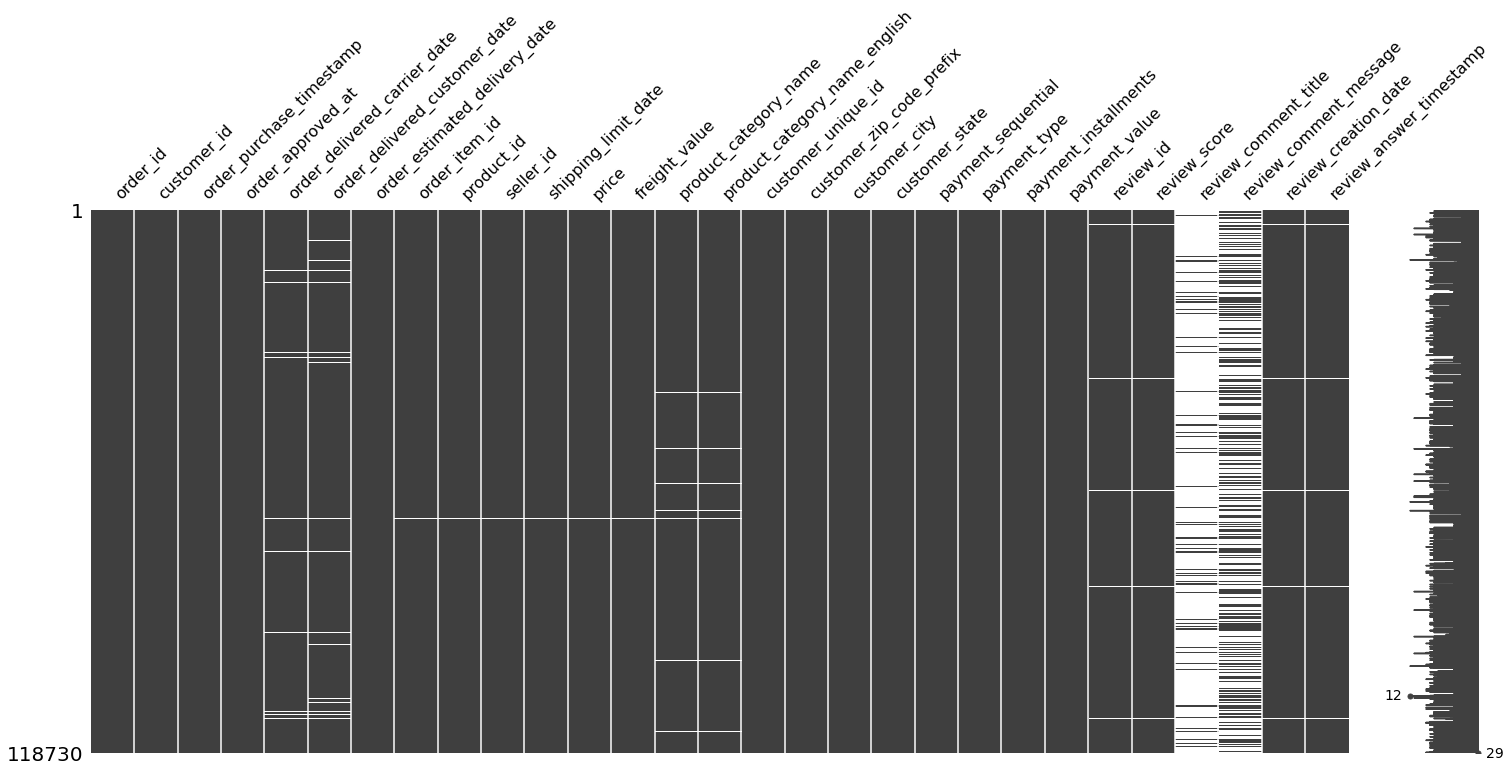

In [45]:
missingno.matrix(raw_dataset)

Secara keseluruhan terlihat bahwa terdapat kolom-kolom yang umumnya memiliki data yang hilang secara berpasangan di antaranya:

- 'order_delivered_carrier_date' dan 'order_delivered_customer_date'
- 'product_category_name' dan 'product_category_name_english'
- 'order_item_date', 'product_id', 'seller_id', 'shipping_limit_date', 'price', dan 'freight_value'
- 'review_id', 'review_score', 'review_creation_date', dan 'review_answer_timestamp'

**'review_comment_title' dan 'review_comment_message'**

Kita dapat melihat bahwa persentase missing value untuk kedua kolom tersebut sangat tinggi yaitu di atas 50%.
Kita asumsikan bahwa customer tidak memberi pesan maupun judul pada saat mengisi survey kepuasan, tetapi hanya memberi score.

In [46]:
raw_dataset["review_comment_title"].fillna("No Title", inplace=True)
raw_dataset["review_comment_message"].fillna("No Message", inplace=True)

**'order_approved_at', 'order_delivered_carrier_date', dan 'order_delivered_customer_date'**

Untuk mengisi missing value pada kolom 'order_approved_at', kita akan menggunakan data 'order_purchase_timestamp' yang ditambahkan rata-rata selisih waktu antara 'order_purchase_timestamp' dan 'order_approved_at'.

Untuk mengisi missing value pada kolom 'order_delivered_carrier_date', kita akan menggunakan data 'order_approved_at' yang ditambahkan rata-rata selisih waktu antara 'order_approved_at' dan 'order_delivered_carrier_date'.

Untuk mengisi missing value pada kolom 'order_delivered_customer_date', kita akan menggunakan data 'order_delivered_carrier_date' yang ditambahkan rata-rata selisih waktu antara 'order_delivered_carrier_date' dan 'order_delivered_customer_date'.

Sehingga kita perlu mencari telebih dahulu rata-rata selisih waktu antara :
- 'order_purchase_timestamp' dan 'order_approved_at'
- 'order_approved_at' dan 'order_delivered_carrier_date' 
- 'order_delivered_carrier_date' dan 'order_delivered_customer_date'

In [47]:
# Membuat dataframe berisi 'order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', dan 'order_delivered_customer_date'
df_time = raw_dataset[['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date']].copy()

In [48]:
# Menghitung banyakanya duplikat waktu
df_time.duplicated().sum()

19623

In [49]:
# Menghapus duplikat sehingga didapat data yang unik untuk kombinasi 
# 'order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date', dan 'order_delivered_customer_date'
df_time = df_time.drop_duplicates()

In [50]:
# Menambahkan kolom yang menghitung selisih waktu antara pembelian hingga payment approval
df_time['purchase_to_approve'] = df_time['order_approved_at'] - df_time['order_purchase_timestamp']

# Menambahkan kolom yang menghitung selisih waktu antara payment approval hingga dikirim ke carrier
df_time['approve_to_carrier'] = df_time['order_delivered_carrier_date'] - df_time['order_approved_at']

# Menambahkan kolom yang menghitung selisih waktu antara pengiriman ke carrier hingga dikirim ke customer
df_time['carrier_to_customer'] = df_time['order_delivered_customer_date'] - df_time['order_delivered_carrier_date']

df_time.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,purchase_to_approve,approve_to_carrier,carrier_to_customer
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,0 days 00:10:42,2 days 08:47:45,6 days 01:30:13
3,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,1 days 06:42:50,0 days 11:06:33,12 days 00:56:45
4,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,0 days 00:16:34,0 days 04:54:37,9 days 04:16:29
5,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,0 days 00:17:53,3 days 17:54:00,9 days 10:48:43
6,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,0 days 01:01:50,0 days 21:26:05,1 days 22:30:28


In [51]:
delta_purchase_to_approve = df_time['purchase_to_approve'].mean()
delta_purchase_to_approve

Timedelta('0 days 10:18:52.673514758')

In [52]:
delta_approve_to_carrier = df_time['approve_to_carrier'].mean()
delta_approve_to_carrier

Timedelta('2 days 18:35:51.103633861')

In [53]:
delta_carrier_to_customer = df_time['carrier_to_customer'].mean()
delta_carrier_to_customer

Timedelta('9 days 08:10:25.529474133')

In [54]:
raw_dataset['order_approved_at'].fillna(raw_dataset['order_purchase_timestamp'] + delta_purchase_to_approve, inplace=True)
raw_dataset['order_delivered_carrier_date'].fillna(raw_dataset['order_approved_at'] + delta_approve_to_carrier, inplace=True)
raw_dataset['order_delivered_customer_date'].fillna(raw_dataset['order_delivered_carrier_date'] + delta_carrier_to_customer, inplace=True)

**'product_category_name' dan 'product_category_name_english'**

Untuk 'product_category_name' dan 'product_category_name_english' yang tidak kita ketahui kategorinya akan kita isi dengan informasi 'diversas' dan 'miscellaneous' secara bertutut-turut. 

In [55]:
raw_dataset["product_category_name"].fillna("diversas", inplace=True)
raw_dataset["product_category_name_english"].fillna("miscellaneous", inplace=True)

**'order_item_id'**

Untuk mengisi 'order_item_id', kita akan mengecek dulu data yang 'order_item_id'-nya adalah null

In [56]:
# Memfilter data pada 'raw_dataset' yang 'order_item_id'-nya adalah null
df_order_item_null = raw_dataset[raw_dataset['order_item_id'].isna()]

In [57]:
# Membuat aggregasi untuk mendapat informasi jumlah 'customer_id' dan 
# jumlah unik value pada kolom 'payment_sequential' serta 'review_id' untuk masing-masing order_id
df_order_item_null_agg = df_order_item_null.groupby('order_id').agg({'customer_id':'count',
                                    'payment_sequential':'nunique',
                                    'review_id':'nunique'}).sort_values('customer_id', ascending=False)

In [58]:
# Memfilter data yang memiliki jumlah 'costomer_id' lebih dari 1
df_order_item_null_agg = df_order_item_null_agg[df_order_item_null_agg['customer_id']>1]

# Memperkirakan order_item_id
df_order_item_null_agg['order_item_id'] = df_order_item_null_agg['customer_id'] / df_order_item_null_agg['payment_sequential'] / df_order_item_null_agg['review_id']
df_order_item_null_agg

,customer_id,payment_sequential,review_id,order_item_id
order_id,,,,
48f2d0b950703bfb145b7c3c0641b4bb,10,10,1,1.0
0b398dbb3e7c81005f3c69b01488c4c9,9,9,1,1.0
896fbd78a9ef3839b34b893f48f6bc67,8,8,1,1.0
1857e77a4bad8abb2db929f107430663,6,6,1,1.0
b34369ee8397436dd7ceb8bb7783671d,4,4,1,1.0
59798edc300f7563a9bdf18b2740def9,4,4,1,1.0
cdf36cd4632fe33085adec5cf3d6b306,3,3,1,1.0
85a22eb264ad44ff56c4955a66876fed,2,2,1,1.0
08ee9c1b1da47ffd2a7c7163aa134b16,2,2,1,1.0


Kita mengetahui bahwa jumlah 'customer_id' untuk tiap 'order_id' merupakan kombinasi antara 'order_item_id', 'payment_sequential', dan 'review_id'.\
Sehingga kita dapat memperkirakan bahwa 'order_item_id' pada data yang null tersebut adalah 1. Oleh karena itu kita akan menginput 'order_item_id' dengan 1.

In [59]:
raw_dataset["order_item_id"].fillna(1, inplace=True)

**'product_id', 'seller_id', dan 'review_id'**

Missing value pada kolom 'product_id', 'seller_id', dan 'review_id' akan kita isi dengan 'unknown' karena kita tidak mengetahui produk, penjual, dan id review dari item tersebut

In [60]:
raw_dataset["product_id"].fillna('unknown', inplace=True)
raw_dataset["seller_id"].fillna('unknown', inplace=True)
raw_dataset["review_id"].fillna('unknown', inplace=True)

**'price' dan 'freight_value'**

Angka 'price' dan 'freight_value' dapat kita taksir dari 'payment_value'. Hal ini dikarenakan 'payment_value' merupakan penjumlahan dari 'price' dan 'freight_value'.

'Freight_value' sebenarnya akan bergantung kepada jenis item, berat, dan juga jarak angkut yang harus ditempuh. Namun untuk menyederhanakan masalah kita akan hitung menggunakan proporsi antara 'price' dan 'freight_value'.

In [61]:
# Membuat dataframe yang berisi informasi 'price' dan 'freight_value'
df_price_freight = raw_dataset[['order_id', 'order_item_id', 'price', 'freight_value']].copy()

# Menghapus duplikat pada dataset tersebut
df_price_freight = df_price_freight.drop_duplicates(['order_id', 'order_item_id', 'price', 'freight_value'])

In [62]:
# Menghitung proporsi 'price' terhadap 'freight_value'

price_to_freight = df_price_freight['price'].sum()/df_price_freight['freight_value'].sum()
price_to_freight

6.033318722141081

In [63]:
# Menghitung bobot 'price' dan 'freight_value' terhadap 'payment_value'
bobot_price = price_to_freight / (price_to_freight + 1)
bobot_freight = 1 / (price_to_freight + 1)

print(bobot_price, bobot_freight)

0.8578196098447846 0.1421803901552154


Maka kita akan mengisi missing value sebagai berikut:

In [64]:
raw_dataset["price"].fillna(bobot_price * raw_dataset["payment_value"], inplace=True)
raw_dataset["freight_value"].fillna(bobot_freight * raw_dataset["payment_value"], inplace=True)

**'review_score'**

Kita akan mengisi review score dengan rata-rata 

In [65]:
raw_dataset['review_score'].fillna(round(raw_dataset['review_score'].mean(),0), inplace=True)

**'shipping_limit_date', 'review_creation_date', dan 'review_answer_timestamp'**

Untuk mengisi missing value pada kolom 'shipping_limit_date', kita akan menggunakan data 'order_approved_at' yang ditambahkan rata-rata selisih waktu antara 'shipping_limit_date' dan 'order_approved_at'.

Untuk mengisi missing value pada kolom 'review_creation_date', kita akan menggunakan data 'order_delivered_customer_date' yang ditambahkan rata-rata selisih waktu antara 'review_creation_date' dan 'order_delivered_customer_date'.

Untuk mengisi missing value pada kolom 'review_answer_timestamp', kita akan menggunakan data 'review_creation_date' yang ditambahkan rata-rata selisih waktu antara 'review_answer_timestamp' dan 'review_creation_date'.

Sehingga kita perlu mencari telebih dahulu rata-rata selisih waktu antara :
- 'shipping_limit_date' dan 'order_approved_at'
- 'review_creation_date' dan 'order_delivered_customer_date'
- 'review_answer_timestamp' dan 'review_creation_date'

In [66]:
# Membuat dataframe berisi 'order_approved_at', 'order_delivered_customer_date', 'shipping_limit_date', 'review_creation_date', dan 'review_answer_timestamp'
df_shipping_review_time = raw_dataset[['order_approved_at', 'order_delivered_customer_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']].copy()

# Menghapus duplicates
df_shipping_review_time = df_shipping_review_time.drop_duplicates()

In [67]:
# Menambahkan kolom yang menghitung selisih waktu antara payment approval hingga batas pengiriman
df_shipping_review_time['approve_to_shipping'] = df_shipping_review_time['shipping_limit_date'] - df_shipping_review_time['order_approved_at']

# Menambahkan kolom yang menghitung selisih waktu antara waktu barang tiba di customer hingga dibuat permintaan review
df_shipping_review_time['customer_to_review_creation'] = df_shipping_review_time['review_creation_date'] - df_shipping_review_time['order_delivered_customer_date']

# Menambahkan kolom yang menghitung selisih waktu antara pengiriman ke carrier hingga dikirim ke customer
df_shipping_review_time['review_creation_to_answer'] = df_shipping_review_time['review_answer_timestamp'] - df_shipping_review_time['review_creation_date']

df_shipping_review_time.head()

,order_approved_at,order_delivered_customer_date,shipping_limit_date,review_creation_date,review_answer_timestamp,approve_to_shipping,customer_to_review_creation,review_creation_to_answer
0,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-06 11:07:15,2017-10-11,2017-10-12 03:43:48,4 days 00:00:00,0 days 02:34:47,1 days 03:43:48
3,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-07-30 03:24:27,2018-08-08,2018-08-08 18:37:50,4 days 00:00:00,0 days 08:32:15,0 days 18:37:50
4,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-08-13 08:55:23,2018-08-18,2018-08-22 19:07:58,5 days 00:00:00,0 days 05:53:31,4 days 19:07:58
5,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-11-23 19:45:59,2017-12-03,2017-12-05 19:21:58,5 days 00:00:00,0 days 23:31:18,2 days 19:21:58
6,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-19 20:31:37,2018-02-17,2018-02-18 13:02:51,5 days 22:11:08,0 days 05:42:58,1 days 13:02:51


In [68]:
delta_approve_to_shipping = df_shipping_review_time['approve_to_shipping'].mean()
delta_approve_to_shipping

Timedelta('6 days 04:24:27.812568727')

In [69]:
delta_customer_to_review_creation = df_shipping_review_time['customer_to_review_creation'].mean()
delta_customer_to_review_creation

Timedelta('0 days 02:35:02.823617945')

In [70]:
delta_review_creation_to_answer = df_shipping_review_time['review_creation_to_answer'].mean()
delta_review_creation_to_answer

Timedelta('3 days 03:06:20.666475200')

In [71]:
raw_dataset['shipping_limit_date'].fillna(raw_dataset['order_approved_at'] + delta_approve_to_shipping, inplace=True)
raw_dataset['review_creation_date'].fillna(raw_dataset['order_delivered_customer_date'] + delta_customer_to_review_creation, inplace=True)
raw_dataset['review_answer_timestamp'].fillna(raw_dataset['review_creation_date'] + delta_review_creation_to_answer, inplace=True)

Sekarang kita cek berapa jumlah missing value yang masih tersia

In [72]:
raw_dataset.isna().values.sum()

0

Hal tersebut menandkan bahwa sudah tidak terdapat missing value pada dataset yang kita buat

#### 2.6.4 Feature Engineering

Kita akan menambahkan beberapa kolom baru dari hasil ekstraksi kolom 'order_purchase_timestamp' yang kemungkinan dapat digunakan pada proses analisis

In [73]:
raw_dataset['month_order'] = raw_dataset['order_purchase_timestamp'].dt.month_name()
raw_dataset['weekday_order'] = raw_dataset['order_purchase_timestamp'].dt.day_name()
raw_dataset['month_year_order'] = raw_dataset['order_purchase_timestamp'].dt.to_period('M')
raw_dataset['week_order'] = raw_dataset['order_purchase_timestamp'].dt.to_period('W')
raw_dataset['date_order'] = raw_dataset['order_purchase_timestamp'].dt.day
raw_dataset['hour_order'] = raw_dataset['order_purchase_timestamp'].dt.hour

Kita juga akan menambahkan kolom 'customer_state_full' yang berisi state dalam nama panjangnya agar lebih mudah dikenali. 

In [74]:
dict_state = {
    'AC' : 'Acre',
    'AL' : 'Alagoas',
    'AM' : 'Amazonas',
    'AP' : 'Amapá',
    'BA' : 'Bahia',
    'CE' : 'Ceará',
    'DF' : 'Distrito Federal',
    'ES' : 'Espírito Santo',
    'GO' : 'Goiás',
    'MA' : 'Maranhão',
    'MG' : 'Minas Gerais',
    'MS' : 'Mato Grosso do Sul',
    'MT' : 'Mato Grosso',
    'PA' : 'Pará',
    'PB' : 'Paraíba',
    'PE' : 'Pernambuco',
    'PI' : 'Piauí',
    'PR' : 'Paraná',
    'RJ' : 'Rio de Janeiro',
    'RN' : 'Rio Grande do Norte',
    'RO' : 'Rondônia',
    'RR' : 'Roraima',
    'RS' : 'Rio Grande do Sul',
    'SC' : 'Santa Catarina',
    'SE' : 'Sergipe',
    'SP' : 'São Paulo',
    'TO' : 'Tocantins'
}

raw_dataset['customer_state_full'] = raw_dataset['customer_state'].map(dict_state)

Tahapan data preparation selesai, kita akan simpan dataset kita sebagai 'clean_dataset'

In [75]:
clean_dataset = raw_dataset.copy()

## 3. Data Analysis

### 3.1 Descriptive Analysis

Berikut terlampir informasi statistik dari kolom numerikal pada dataset 'raw_dataset'. Kita ingin mengetahui rata-rata, standar deviasi, nilai minimum, median, dan nilai maksimum dari setiap kolom numerik pada dataset :

In [76]:
clean_dataset.describe(include=[np.number], percentiles=[.5]).round(3) \
    .transpose().drop('count', axis=1)

,mean,std,min,50%,max
order_item_id,1.195,0.697,1.0,1.00,21.000
price,120.943,185.246,0.0,74.90,6735.000
freight_value,20.088,16.337,0.0,16.28,537.753
customer_zip_code_prefix,35018.052,29819.629,1003.0,24240.00,99990.000
payment_sequential,1.095,0.731,1.0,1.00,29.000
payment_installments,2.938,2.776,1.0,2.00,24.000
payment_value,172.678,267.973,0.0,108.10,13664.080
review_score,4.017,1.393,1.0,5.00,5.000
date_order,15.582,8.662,1.0,16.00,31.000
hour_order,14.756,5.328,0.0,15.00,23.000


Selanjutnya, kita ingin melihat informasi statistik dari kolom numerikal pada dataset kita.

In [77]:
clean_dataset.describe(include='object').round(3) \
    .transpose().drop('count', axis=1)

,unique,top,freq
order_id,99108,895ab968e7bb0d5659d16cd74cd1650c,63
customer_id,99108,270c23a11d024a44c896d1894b261a83,63
product_id,32788,unknown,812
seller_id,3069,4a3ca9315b744ce9f8e9374361493884,2155
product_category_name,72,cama_mesa_banho,11980
product_category_name_english,72,bed_bath_table,11980
customer_unique_id,95779,9a736b248f67d166d2fbb006bcb877c3,75
customer_city,4116,sao paulo,18833
customer_state,27,SP,50128
payment_type,5,credit_card,87471


### 3.2 Current State of The Business

#### 3.2.1 By Orders

`Total Transaksi Tiap Bulan`

In [78]:
# Membuat dataframe berisi informasi order tiap bulan dari Januari 2017 hingga September 2018
df_monthyear_order = clean_dataset.groupby('month_year_order').nunique().reset_index()[['month_year_order','order_id']]
df_monthyear_order['year'] = df_monthyear_order['month_year_order'].dt.strftime('%Y')
df_monthyear_order['month'] = df_monthyear_order['month_year_order'].dt.strftime('%B')
df_monthyear_order['month_year_order'] = df_monthyear_order['month_year_order'].dt.strftime('%Y-%m')

In [79]:
total_order = df_monthyear_order['order_id'].sum()
total_order

99108

In [80]:
average_order =df_monthyear_order['order_id'].mean()
average_order

4719.428571428572

In [81]:
print(f'Jumlah order yang didapat sepanjang Januari 2017 hingga September 2018 adalah {total_order} pesanan')
print(f'Rata-rata order per bulan sepanjang Januari 2017 hingga September 2018 adalah {average_order:0.2f} pesanan')

Jumlah order yang didapat sepanjang Januari 2017 hingga September 2018 adalah 99108 pesanan
Rata-rata order per bulan sepanjang Januari 2017 hingga September 2018 adalah 4719.43 pesanan


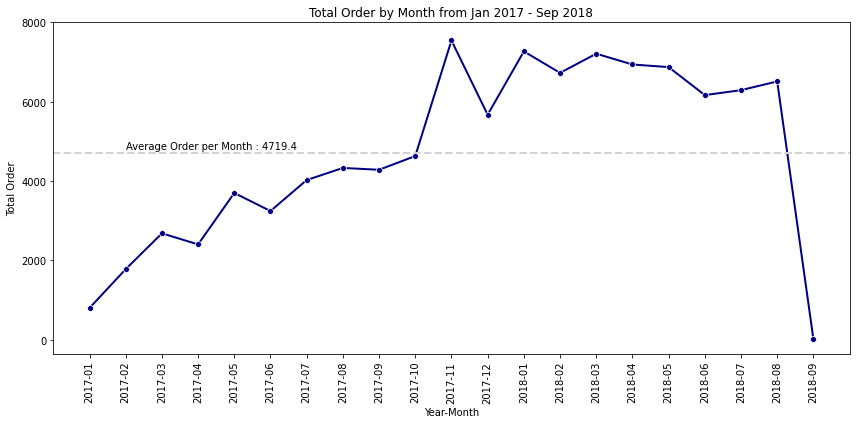

In [82]:
# Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=df_monthyear_order, x='month_year_order', y='order_id', linewidth=2, color='navy', marker='o')
plt.axhline(average_order, color='lightgrey', linestyle='--', linewidth=2)
plt.title('Total Order by Month from Jan 2017 - Sep 2018')
plt.text(1, average_order * 1.02, f'Average Order per Month : {average_order:0.1f}')
plt.xticks(rotation=90)
plt.yticks(range(0,10000,2000))
plt.ylabel('Total Order')
plt.xlabel('Year-Month')

plt.tight_layout()
plt.show()

> - Jumlah order pada tahun 2017 cenderung meningkat dengan capaian tertinggi terjadi pada bulan November 2017. Tingginya transaksi kita asumsikan terjadi dikarenakan adanya momen Black Friday serta Final CONMEBOL dimana Brasil menjadi juaranya pada bulan tersebut.
> - Sedangkan jumlah order pada tahun 2018 cenderung stagnan dengan jumlah order terendah di bulan September. Hal ini bisa saja disebabkan jumlah data yang masuk pada bulan tersebut belumlah lengkap.

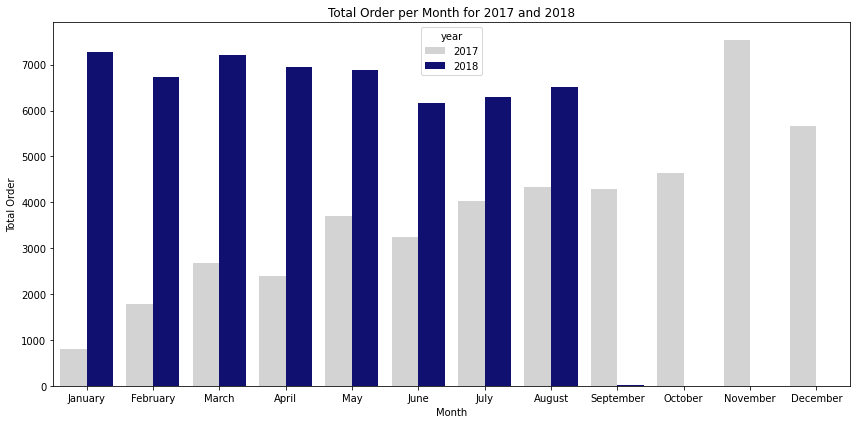

In [83]:
# Visualization
plt.figure(figsize=(12,6))
sns.barplot(data=df_monthyear_order, x='month', y='order_id', hue='year', ci=None, palette=["lightgrey", "navy"])
plt.title('Total Order per Month for 2017 and 2018')
plt.ylabel('Total Order')
plt.xlabel('Month')

plt.tight_layout()
plt.show()

> - Jumlah order pada masing-masing bulan di tahun 2018 relatif lebih tinggi dibandingkan jumlah order pada bulan yang sama di tahun 2017.
> - Namun terdapat kecenderungan penurunan pertumbuhan order pada bulan yang sama untuk tahun yang berbeda

In [84]:
crosstab_order = pd.crosstab(index = df_monthyear_order['month'], columns = df_monthyear_order['year'],\
                  values = df_monthyear_order['order_id'], aggfunc = 'sum').fillna(0)\
                    .reindex(['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 
                    'September', 'October', 'November', 'December'], axis=0)

crosstab_order['% change (Month-over-Month) '] = round((crosstab_order['2018'] - crosstab_order['2017']) / crosstab_order['2017'] * 100,2)
crosstab_order

year,2017,2018,% change (Month-over-Month)
month,,,
January,800.0,7269.0,808.62
February,1780.0,6728.0,277.98
March,2682.0,7211.0,168.87
April,2404.0,6939.0,188.64
May,3700.0,6873.0,85.76
June,3245.0,6167.0,90.05
July,4026.0,6292.0,56.28
August,4331.0,6512.0,50.36
September,4285.0,16.0,-99.63


`Total Transaksi Berdasarkan Hari`

In [85]:
# Membuat dataframe berisi informasi order per hari dari Januari 2017 hingga September 2018
df_weekday_order = clean_dataset.groupby('weekday_order').nunique().reset_index()[['weekday_order','order_id']]

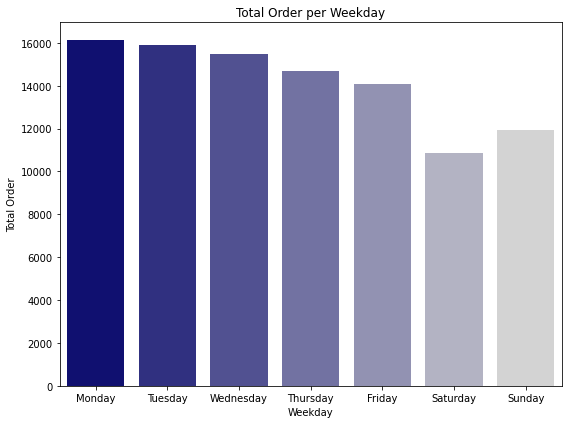

In [86]:
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
color_palette = sns.blend_palette(['navy', 'lightgrey'], 7)

# Visualization
plt.figure(figsize=(8,6))
sns.barplot(data=df_weekday_order, x='weekday_order', y='order_id', ci=None, order=weekday, palette=color_palette)
plt.title('Total Order per Weekday')
plt.ylabel('Total Order')
plt.xlabel('Weekday')

plt.tight_layout()
plt.show()

>- Terlihat bahwa order tertinggi terjadi di hari Senin sedangkan yang terendah terjadi di hari Sabtu.
>- Secara umum transaksi berangsur turun mendekati akhir pekan (Sabtu dan Minggu)
>- Transaksi pada hari kerja relatih lebih tinggi dibandingkan transaksi pada akhir pekan
>- Sebaiknya perusahaan melakukan promosi di hari kerja sehingga dapat dijangkau oleh banyak customer.

`Total Transaksi Berdasarkan Tanggal`

In [87]:
# Membuat dataframe berisi informasi order per tanggal dari Januari 2017 hingga September 2018
df_date_order = clean_dataset.groupby('date_order').nunique().reset_index()[['date_order','order_id']]

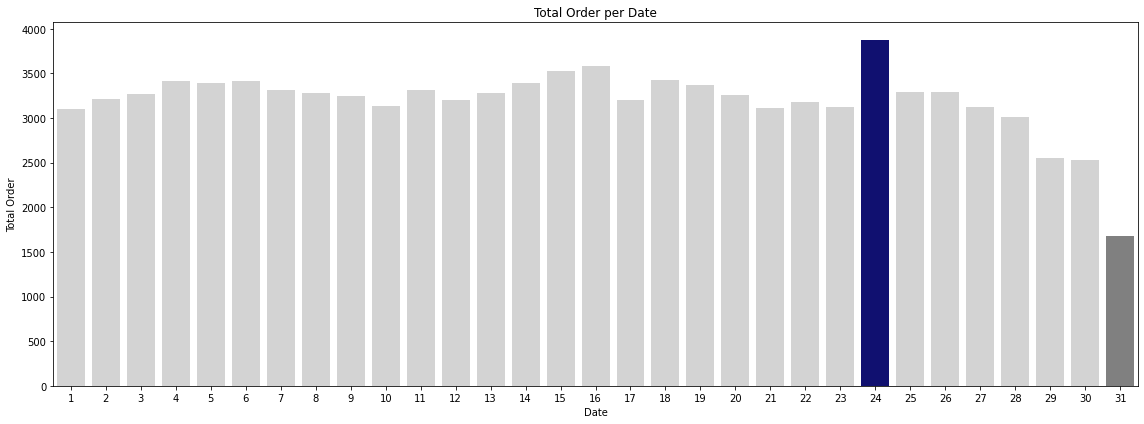

In [88]:
color_palette = ['lightgrey'] * 23 + ['navy']  + ['lightgrey'] * 6 + ['grey']

# Visualization
plt.figure(figsize=(16,6))
sns.barplot(data=df_date_order, x='date_order', y='order_id', ci=None, palette=color_palette)
plt.title('Total Order per Date')
plt.ylabel('Total Order')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

>- Transaksi tertinggi terjadi pada tanggal 24 dimana tanggal tersebut umumnya merupakan tanggal gajian di Brasil
>- Transaksi terendah umumnya terjadi pada akhir bulan sekitara tanggal 29 hingga 31.
>- Sebaiknya kegiatan promosi dilakukan pada saat payday karena customer cenderung melakukan transaksi pada tanggal tersebut.

`Total Transaksi Berdasarkan Jam`

In [89]:
# Membuat dataframe berisi informasi order per jam dari Januari 2017 hingga September 2018
df_hour_order = clean_dataset.groupby('hour_order').nunique().reset_index()[['hour_order','order_id']]

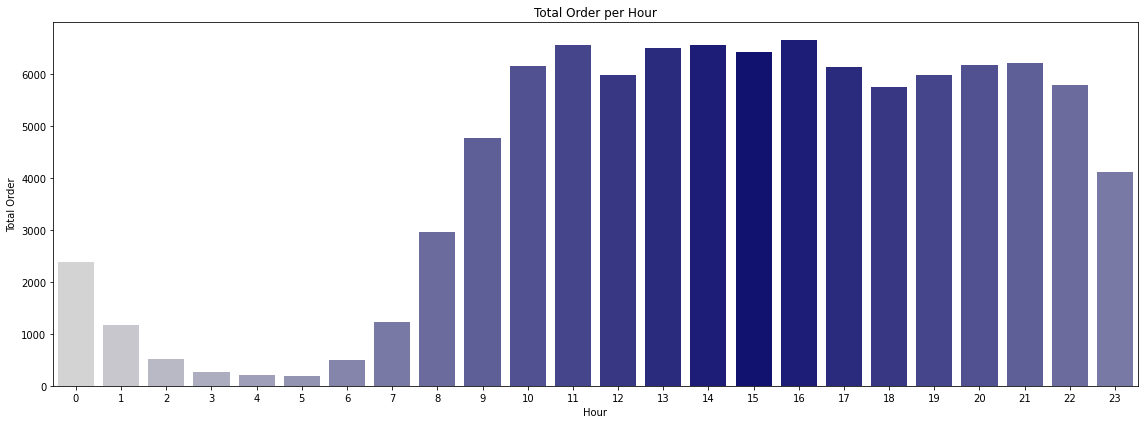

In [90]:
color_palette = sns.blend_palette(['lightgrey', 'navy', 'lightgrey'], 31)

# Visualization
plt.figure(figsize=(16,6))
sns.barplot(data=df_hour_order, x='hour_order', y='order_id', ci=None, palette=color_palette)
plt.title('Total Order per Hour')
plt.ylabel('Total Order')
plt.xlabel('Hour')

plt.tight_layout()
plt.show()

>- Berdasarkan grafik di atas, jumlah transaksi tertinggi terjadi di waktu kerja pada pukul 11:00 - 17:00 kemudian dilanjut pukul 20:00 - 22:00
>- Sedangkan transaksi terendah terjadi di waktu pada pukul 3:00 - 6:00
>- Dari grafik juga dapat kita asumsikan bahwa jumlah transaksi cenderung bersifat siklikal dimana transaksi cenderung naik dari pukul6:00 - 22:00 kemudian berangsur turun pada pukul 22:00 - 6:00.

In [91]:
# Membuat dataframe berisi informasi order per jam per hari dari Januari 2017 hingga September 2018
df_day_hour_order = clean_dataset.groupby(['weekday_order', 'hour_order']).nunique().reset_index()[['weekday_order', 'hour_order','order_id']]

In [92]:
# Membuat crosstab dengan index beupa nama hari, kolom berupa jam, dan value berupa jumlah order.
crosstab_day_hour = pd.crosstab(index = df_day_hour_order['weekday_order'], columns = df_day_hour_order['hour_order'],\
                  values = df_day_hour_order['order_id'], aggfunc = 'sum')\
                  .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],axis=0)

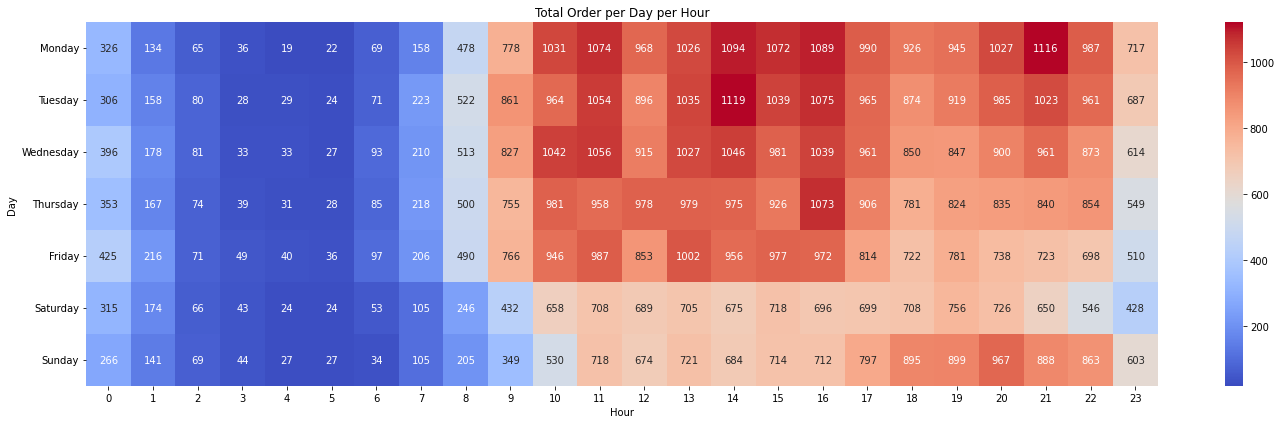

In [93]:
# Visualization
plt.figure(figsize=(20,6))
sns.heatmap(crosstab_day_hour,annot=True,fmt="d",cmap='coolwarm')
plt.xlabel("Hour")
plt.ylabel("Day")
plt.title("Total Order per Day per Hour",size=12)

plt.tight_layout()
plt.show()

>- Berdasarkan heatmap di atas terlihat bahwa transaksi tertinggi di hari kerja (Senin - Jumat) cenderung terjadi pada pukul 10:00 - 23:00 
>- Sedangkan di akhir pekan, khususnya hari Minggu, transaksi tertinggi cenderung terjadi sekitar pukul 17:00 - 23:00. Kita dapat asumsikan bahwa pada siang hari di akhir pekan, customer justru cenderung sibuk untuk melakukan aktivitas baik sendiri ataupun bersama keluarga atau teman.
>- Sebaiknya perusahaan melakukan promosi pada jam-jam dengan aktivitas tertinggi tersebut misal dengan cara:
>- 1. Pemberian voucher khusus & diskon yang berlaku pada pembelian di hari kerja.
>- 2. Pemberian voucher khusus & diskon yang berlaku pada pembelian di jam malam akhir pekan
>- 3. Melakukan kampanye marketing seperti broadcast dan iklan sebelum jam 9 pagi dimana frekuensi transaksi mulai meningkat.

#### 3.2.2 By Payment Value

`Total Pendapatan Tiap Bulan`

In [94]:
# Mengcopy dataset 'clean_dataset' dan menghapus data dengan order_id, payment_sequential, dan 'payment_value' yang sama.
df_payment = clean_dataset.copy().drop_duplicates(['order_id', 'payment_sequential', 'payment_value'])

In [95]:
# Membuat dataframe berisi informasi payment value tiap bulan dari Januari 2017 hingga September 2018
df_monthyear_payment = df_payment.groupby('month_year_order').sum().reset_index()[['month_year_order','payment_value']]
df_monthyear_payment['year'] = df_monthyear_payment['month_year_order'].dt.strftime('%Y')
df_monthyear_payment['month'] = df_monthyear_payment['month_year_order'].dt.strftime('%B')
df_monthyear_payment['month_year_order'] = df_monthyear_payment['month_year_order'].dt.strftime('%Y-%m')

In [96]:
total_revenue =df_monthyear_payment['payment_value'].sum()
total_revenue

15948920.11

In [97]:
average_revenue =df_monthyear_payment['payment_value'].mean()
average_revenue

759472.3861904761

In [98]:
print(f'Jumlah pendapatan yang didapat sepanjang Januari 2017 hingga September 2018 adalah {total_revenue} Real Brazil')
print(f'Rata-rata pendapatan per bulan sepanjang Januari 2017 hingga September 2018 adalah {average_revenue:0.2f} Real Brazil')

Jumlah pendapatan yang didapat sepanjang Januari 2017 hingga September 2018 adalah 15948920.11 Real Brazil
Rata-rata pendapatan per bulan sepanjang Januari 2017 hingga September 2018 adalah 759472.39 Real Brazil


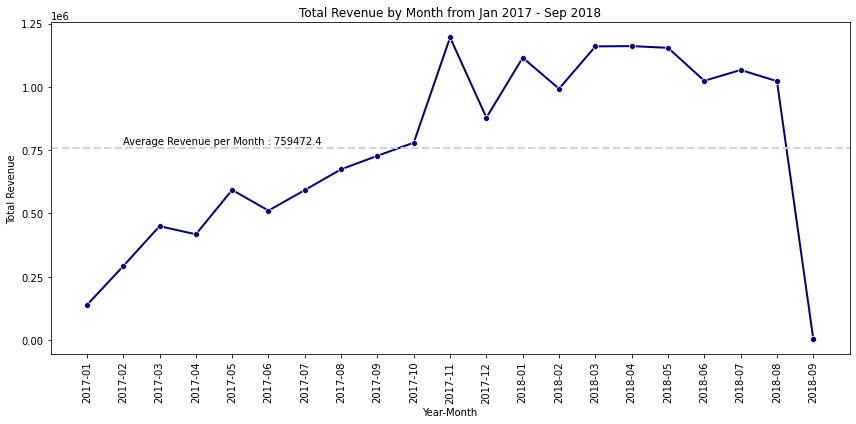

In [99]:
# Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=df_monthyear_payment, x='month_year_order', y='payment_value', linewidth=2, color='navy', marker='o')
plt.axhline(average_revenue, color='lightgrey', linestyle='--', linewidth=2)
plt.title('Total Revenue by Month from Jan 2017 - Sep 2018')
plt.text(1, average_revenue * 1.02, f'Average Revenue per Month : {average_revenue:0.1f}')
plt.xticks(rotation=90)
plt.yticks(range(0,1500000,250000))
plt.ylabel('Total Revenue')
plt.xlabel('Year-Month')

plt.tight_layout()
plt.show()

> - Jumlah pendapatan pun cenderung sama dengan jumlah transaksi dimana pada tahun 2017 cenderung meningkat dengan capaian tertinggi terjadi pada bulan November 2017.
> - Sedangkan jumlah pendapatan pada tahun 2018 cenderung stagnan walaupun masih di atas rata-rata pendapatan Januari 2017 hingga September 2018.

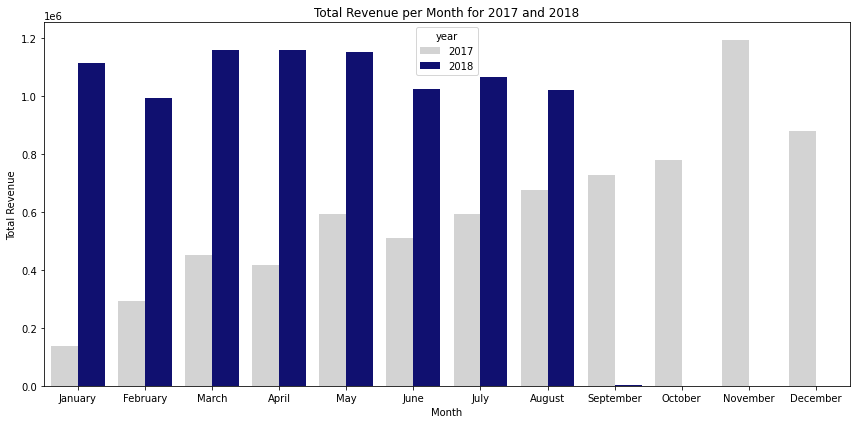

In [100]:
# Visualization
plt.figure(figsize=(12,6))
sns.barplot(data=df_monthyear_payment, x='month', y='payment_value', hue='year', ci=None, palette=["lightgrey", "navy"])
plt.title('Total Revenue per Month for 2017 and 2018')
plt.ylabel('Total Revenue')
plt.xlabel('Month')

plt.tight_layout()
plt.show()

> - Jumlah pendapatan pada masing-masing bulan di tahun 2018 relatif lebih tinggi dibandingkan jumlah pendapatan pada bulan yang sama di tahun 2017.
> - Namun terdapat kecenderungan penurunan pertumbuhan pendapatan pada bulan yang sama untuk tahun yang berbeda

In [101]:
# menghitung total pendapatan Jan - Aug 2018
revenue_8M2018 = df_monthyear_payment.iloc[12:20]['payment_value'].sum()

# menghitung total pendapatan Jan - Aug 2017
revenue_8M2017 = df_monthyear_payment.iloc[:8]['payment_value'].sum()

# menghitung pertumbuhan pendaptan periode 8M2018 vs 8M2017
persen_kenaikan = (revenue_8M2018 - revenue_8M2017) * 100.0 / revenue_8M2017

print(f'Persentase kenaikan penjualan 8M2018 vs 8M2017 adalah sebesar {persen_kenaikan:.2f}%')

Persentase kenaikan penjualan 8M2018 vs 8M2017 adalah sebesar 136.98%


`Average Order Value Tiap Bulan`

In [102]:
# Menggabung dataset df_monthyear_order dan df_monthyear_payment
df_aov = pd.concat([df_monthyear_order, df_monthyear_payment], axis=1).iloc[:,[0,5,1]] # hanya kolom month_year_order, payment_value, order_id

# Menambahkan kolom Average Order Value = Pendapatan/Jumlah Pesanan
df_aov['average_order_value'] = round(df_aov['payment_value'] / df_aov['order_id'],1)

In [103]:
# Menghitung average order value untuk periode Januari 2017 - September 2018

average_aov = round(df_aov['payment_value'].sum() / df_aov['order_id'].sum(),1)
average_aov

160.9

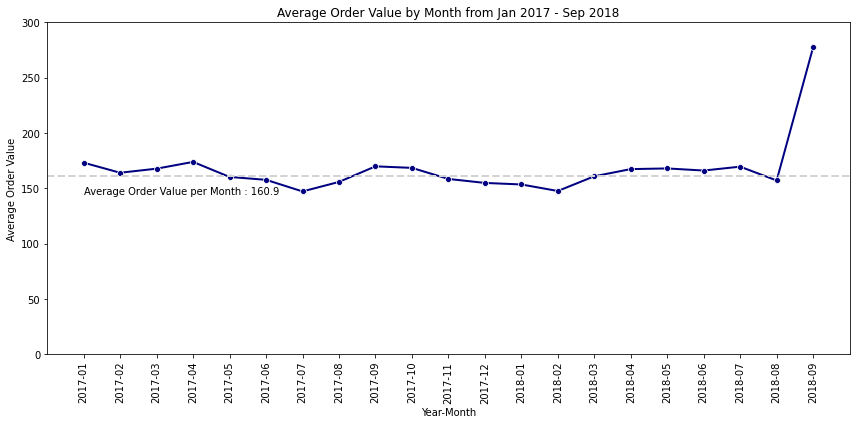

In [104]:
# Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=df_aov, x='month_year_order', y='average_order_value', linewidth=2, color='navy', marker='o')
plt.axhline(average_aov, color='lightgrey', linestyle='--', linewidth=2)
plt.title('Average Order Value by Month from Jan 2017 - Sep 2018')
plt.text(0, average_aov * 0.9, f'Average Order Value per Month : {average_aov:0.1f}')
plt.xticks(rotation=90)
plt.yticks(range(0,350,50))
plt.ylabel('Average Order Value')
plt.xlabel('Year-Month')

plt.tight_layout()
plt.show()

>- Berdasarkan Average Order Value (AOV), AOV tiap bulannya cenderung stabil dengan rata-rata di angka sekitar 160.9 Real Brasil per order.
>- Sehingga terlihat bahwa perusahaan masih belum mampu meningkatkan rata-rata nilai transaksi pelanggannya dalam 2 tahun kebelakang

`Total Pendapatan Berdasarkan Metode Pembayaran`

In [105]:
# Membuat dataframe berisi informasi payment value berdasarkan cara pembayaran dari Januari 2017 hingga September 2018
df_type_payment = df_payment.groupby('payment_type').sum().reset_index()[['payment_type','payment_value']].sort_values('payment_value', ascending=False)

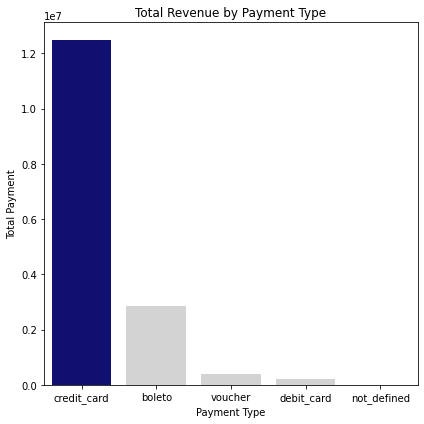

In [106]:
color_palette = ['navy'] + ['lightgrey'] * 4

# Visualization
plt.figure(figsize=(6,6))
sns.barplot(data=df_type_payment, x='payment_type', y='payment_value', ci=None, palette=color_palette)
plt.title('Total Revenue by Payment Type')
plt.ylabel('Total Payment')
plt.xlabel('Payment Type')

plt.tight_layout()
plt.show()

> - Cara pembayaran yang paling diminati oleh customer adalah melaui credit card, disusul oleh boleto (pembayaran online/offline paling populer di Brasil) dan voucher.
> - Oleh karenya perusahaan harus menerapkan sistem Fraud Detection untuk mencegah terjadinya potensi penyalahagunaan credit carad yang dapat berdampak pada hilangnya kepercayaan customer.

In [107]:
# Memfilter dataset dengan tipe pembayaran boleto
df_boleto = df_payment[df_payment['payment_type']=='boleto']

# Membuat dataframe berisi informasi revenue untuk pembayaran melalui boleto pada tiap bulan dari Januari 2017 hingga September 2018
df_monthyear_boleto = df_boleto.groupby('month_year_order').sum().reset_index()[['month_year_order','payment_value']]
df_monthyear_boleto['month_year_order'] = df_monthyear_boleto['month_year_order'].dt.strftime('%Y-%m')

In [108]:
average_payment_boleto =df_monthyear_boleto['payment_value'].mean()
average_payment_boleto

142984.11049999998

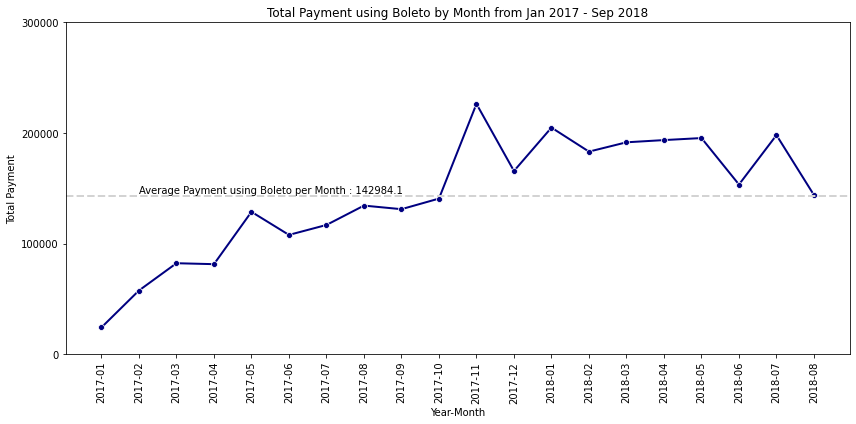

In [109]:
# Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=df_monthyear_boleto, x='month_year_order', y='payment_value', linewidth=2, color='navy', marker='o')
plt.axhline(average_payment_boleto, color='lightgrey', linestyle='--', linewidth=2)
plt.title('Total Payment using Boleto by Month from Jan 2017 - Sep 2018')
plt.text(1, average_payment_boleto * 1.02, f'Average Payment using Boleto per Month : {average_payment_boleto:0.1f}')
plt.xticks(rotation=90)
plt.yticks(range(0,400000,100000))
plt.ylabel('Total Payment')
plt.xlabel('Year-Month')

plt.tight_layout()
plt.show()

>- Tren penggunaan boleto dalam pembayaran cenderung sesuai dengan tren transaksi dimana naik pada tahun 2017 dengan puncaknya di bulan November 2017 dan cenderung stagnan pada tahun 2018.

In [110]:
# Memfilter dataset dengan tipe pembayaran voucher
df_voucher = df_payment[df_payment['payment_type']=='voucher']

# Membuat dataframe berisi informasi revenue untuk pembayaran melalui voucher pada tiap bulan dari Januari 2017 hingga September 2018
df_monthyear_voucher = df_voucher.groupby('month_year_order').sum().reset_index()[['month_year_order','payment_value']]
df_monthyear_voucher['month_year_order'] = df_monthyear_voucher['month_year_order'].dt.strftime('%Y-%m')

In [111]:
average_payment_voucher =df_monthyear_voucher['payment_value'].mean()
average_payment_voucher

17998.48238095238

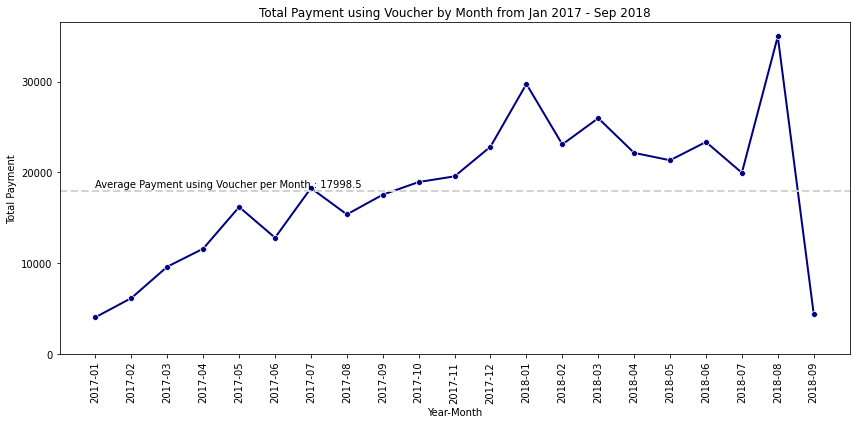

In [112]:
# Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=df_monthyear_voucher, x='month_year_order', y='payment_value', linewidth=2, color='navy', marker='o')
plt.axhline(average_payment_voucher, color='lightgrey', linestyle='--', linewidth=2)
plt.title('Total Payment using Voucher by Month from Jan 2017 - Sep 2018')
plt.text(0, average_payment_voucher * 1.02, f'Average Payment using Voucher per Month : {average_payment_voucher:0.1f}')
plt.xticks(rotation=90)
plt.yticks(range(0,40000,10000))
plt.ylabel('Total Payment')
plt.xlabel('Year-Month')

plt.tight_layout()
plt.show()

>- Sedangkan tren penggunaan voucher dalam pembayaran cenderung meningkat pada tahun 2017 kemudian turun pada tahun 2018 sebelum kembali naik pada Agustus 2018.

`Total Transaksi Berdasarkan Frekuensi Pembayaran`

In [113]:
# Membuat dataframe yang berisi informasi banyaknya jumlah pesanan dikelompokkan berdasarkan frekuensi pembayaran
df_order_installment = df_payment[['order_id','payment_installments']].groupby('order_id').max().reset_index()
df_order_installment = df_order_installment.groupby('payment_installments').nunique().reset_index()

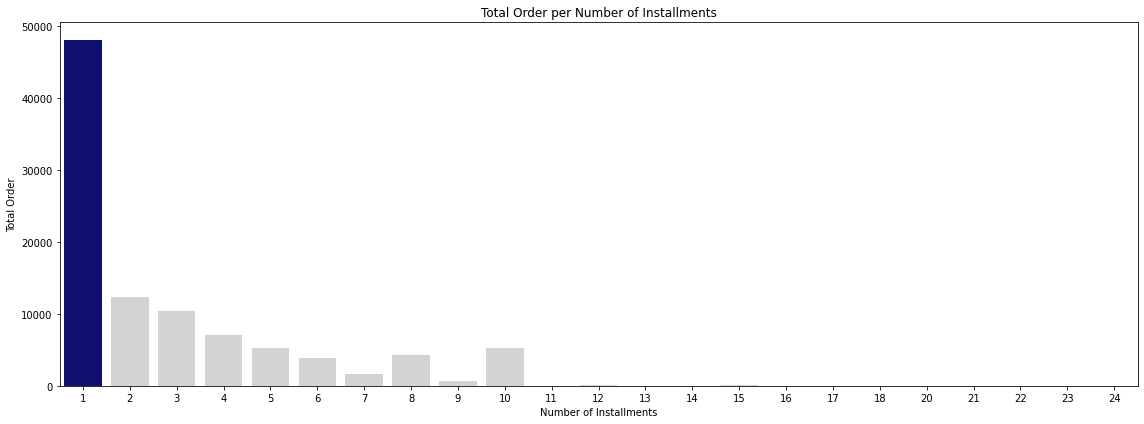

In [114]:
color_palette = ['navy'] + ['lightgrey'] * 23

# Visualization
plt.figure(figsize=(16,6))
sns.barplot(data=df_order_installment, x='payment_installments', y='order_id', ci=None, palette=color_palette)
plt.title('Total Order per Number of Installments')
plt.ylabel('Total Order')
plt.xlabel('Number of Installments')

plt.tight_layout()
plt.show()

>- Terlihat bahwa sebagian besar transaksi yang dilakukan oleh customer dibayar dengan metode tanpa cicilan.
>- Adapun metode cicilan yang umumnya dipilih oleh customer adalah cicilan sebanyak 2 hingga 10 kali.


`Average Order Value Berdasarkan Frekuensi Pembayaran`

In [115]:
# Membuat dataframe yang berisi informasi pendapatan dikelompokkan berdasarkan frekuensi pembayaran
df_payment_installment = df_payment[['payment_value','payment_installments']].groupby('payment_installments').sum().reset_index()
df_aov_installment = pd.concat([df_payment_installment, df_order_installment], axis=1).iloc[:,[0,1,3]]
df_aov_installment['average_order_value'] = round(df_aov_installment['payment_value']/df_aov_installment['order_id'],1)

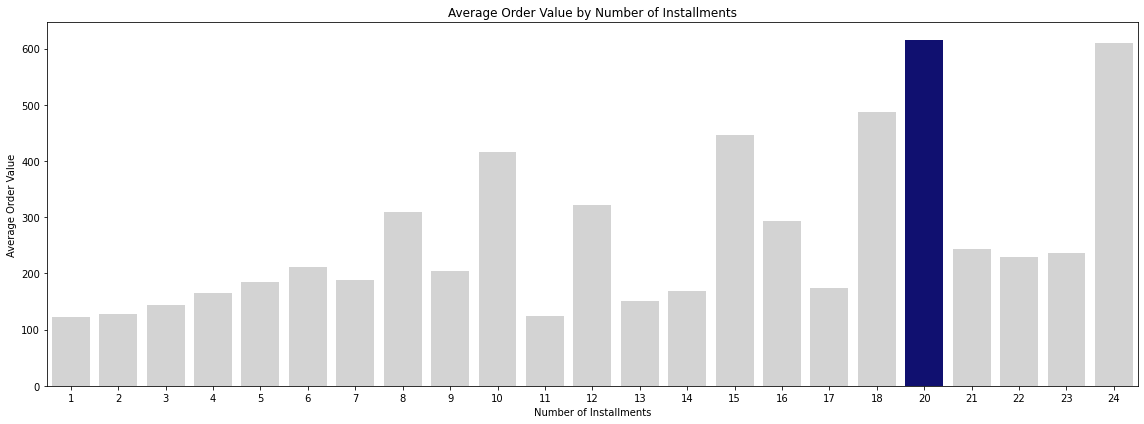

In [116]:
color_palette = ['lightgrey'] * 18 + ['navy'] + ['lightgrey'] * 5

# Visualization
plt.figure(figsize=(16,6))
sns.barplot(data=df_aov_installment, x='payment_installments', y='average_order_value', ci=None, palette=color_palette)
plt.title('Average Order Value by Number of Installments')
plt.ylabel('Average Order Value')
plt.xlabel('Number of Installments')

plt.tight_layout()
plt.show()

>- Sedangkan jika dilihat berdasarkan AOV-nya, AOV tertinggi cenderung terjadi pada cicilan di atas 10 kali dengan puncaknya pada cicilan sebanyak 20 kali.
>- Sehingga perusahaan sebaiknuya menerapak strategi marketing seperti :
>- 1. Memberikan potongan harga dengan minimal transaksi yang cukup tinggi 
>- 2. Memberikan kemudahan dan insentif khusus (misal bunga rendah atau 0%, free biaya admin) dalam pemberian cicilan
>- sehingga pelanggan lebih tertarik untuk berbelanja dan mengeluarkan lebih banyak uang untuk membeli suatu barang.

#### 3.2.3 By Product

`Product Category yang Paling Laris`

In [117]:
# Membuat aggregasi untuk mendapat informasi jumlah 'payment value' dan 
# jumlah unik value pada kolom 'order_id' untuk masing-masing kategori product
df_category_agg = df_payment[['product_category_name_english','payment_value', 'order_id']].groupby('product_category_name_english')\
                            .agg({'payment_value':'sum','order_id':'nunique'}).sort_values('payment_value', ascending=False)\
                            .reset_index()

df_category_agg['average_order_value'] = round(df_category_agg['payment_value']/df_category_agg['order_id'],1)
df_category_agg.head()

,product_category_name_english,payment_value,order_id,average_order_value
0,health_beauty,1434564.49,8752,163.9
1,watches_gifts,1299691.48,5596,232.3
2,bed_bath_table,1239835.61,9306,133.2
3,sports_leisure,1153827.22,7662,150.6
4,computers_accessories,1055890.01,6642,159.0


In [118]:
top10_revenue = df_category_agg.sort_values('payment_value', ascending=False).iloc[:10]
top10_transaction = df_category_agg.sort_values('order_id', ascending=False).iloc[:10]
top10_aov = df_category_agg.sort_values('average_order_value', ascending=False).iloc[:10]

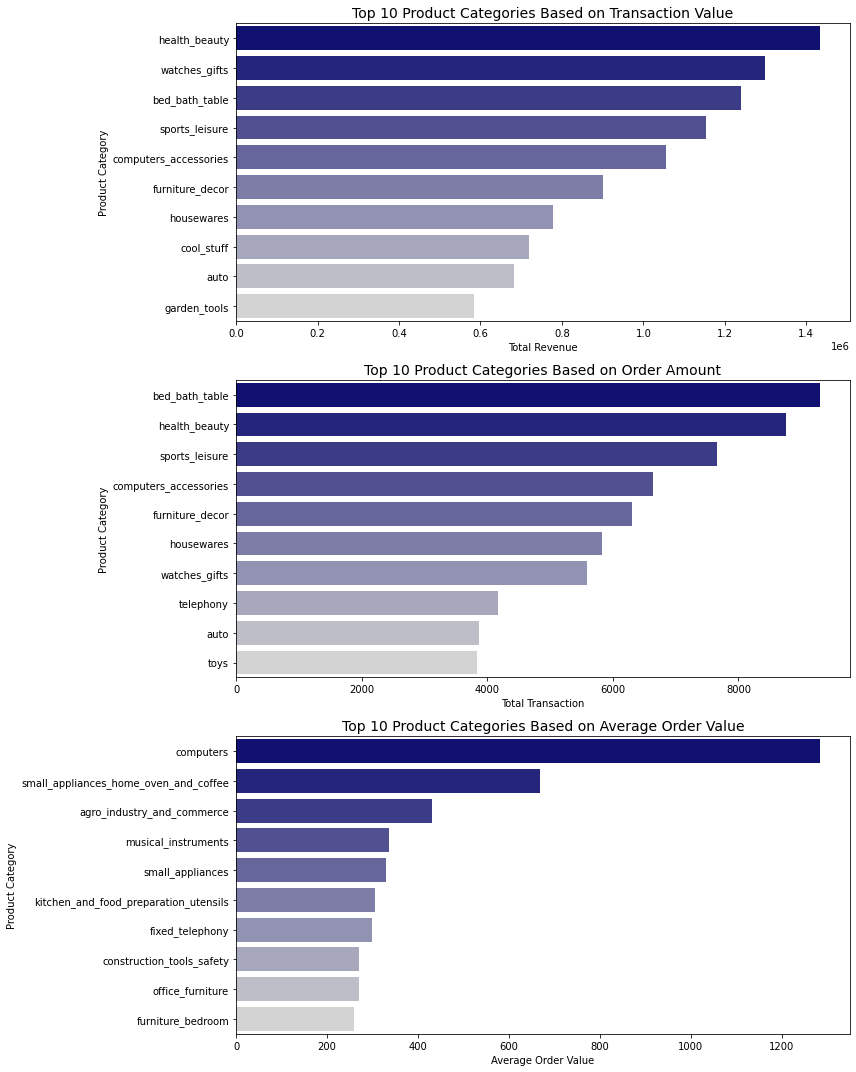

In [119]:
color_palette = sns.blend_palette(['navy', 'lightgrey'], 10)

fig, axes = plt.subplots(3, 1, figsize=(12,15))

ax1 = sns.barplot(data=top10_revenue, y='product_category_name_english', x='payment_value', ax=axes[0], palette=color_palette)
ax1.set_ylabel('Product Category')
ax1.set_xlabel('Total Revenue')
ax1.set_title('Top 10 Product Categories Based on Transaction Value',fontsize=14)

ax2 = sns.barplot(data=top10_transaction, y='product_category_name_english', x='order_id', ax=axes[1], palette=color_palette)
ax2.set_ylabel('Product Category')
ax2.set_xlabel('Total Transaction')
ax2.set_title('Top 10 Product Categories Based on Order Amount',fontsize=14)

ax3 = sns.barplot(data=top10_aov, y='product_category_name_english', x='average_order_value', ax=axes[2], palette=color_palette)
ax3.set_ylabel('Product Category')
ax3.set_xlabel('Average Order Value')
ax3.set_title('Top 10 Product Categories Based on Average Order Value',fontsize=14)

plt.tight_layout()
plt.show()

> - Kategori produk dengan nilai transaksi paling tinggi adalah *health_beauty*, lalu diikuti oleh *watches_gift*, dan *bad_bath_table*.
> - Kategori produk dengan jumlah kuantitas pesanan terbanyak adalah *bed_bath_table*, diikuti oleh *health_beauty* dan *sport_leisure*
> - Namun jika dilihat berdasarkan AOV-nya, kategori produk dengan nilai rata-rata transaksi tertinggi adalah *computers*, diikuti oleh *small_appliances_home_oven_and_coffee* dan *agro_industry_and_ecommerce*
> - Sebaiknya perusahaan rutin mempromosikan produk produk dengan AOV tinggi agar produk tersebut dapat meningkat jumlah pesanannya sehingga turut mendongkrak pendapatan.


#### 3.2.4 By State

`State dengan Jumlah Transaksi dan Pendapatan Terbesar`

In [120]:
# Membuat aggregasi untuk mendapat informasi jumlah 'payment value' dan 
# jumlah unik value pada kolom 'order_id' untuk masing-masing state
df_state_agg = df_payment[['customer_state_full','payment_value', 'order_id']].groupby('customer_state_full')\
                            .agg({'payment_value':'sum','order_id':'nunique'}).sort_values('payment_value', ascending=False)\
                            .reset_index()

df_state_agg['average_order_value'] = round(df_state_agg['payment_value']/df_state_agg['order_id'],1)
df_state_agg.head()

,customer_state_full,payment_value,order_id,average_order_value
0,São Paulo,5981054.16,41629,143.7
1,Rio de Janeiro,2130891.73,12795,166.5
2,Minas Gerais,1866614.29,11595,161.0
3,Rio Grande do Sul,886107.84,5441,162.9
4,Paraná,808556.41,5025,160.9


In [121]:
state_revenue = df_state_agg.sort_values('payment_value', ascending=False)
state_transaction = df_state_agg.sort_values('order_id', ascending=False)

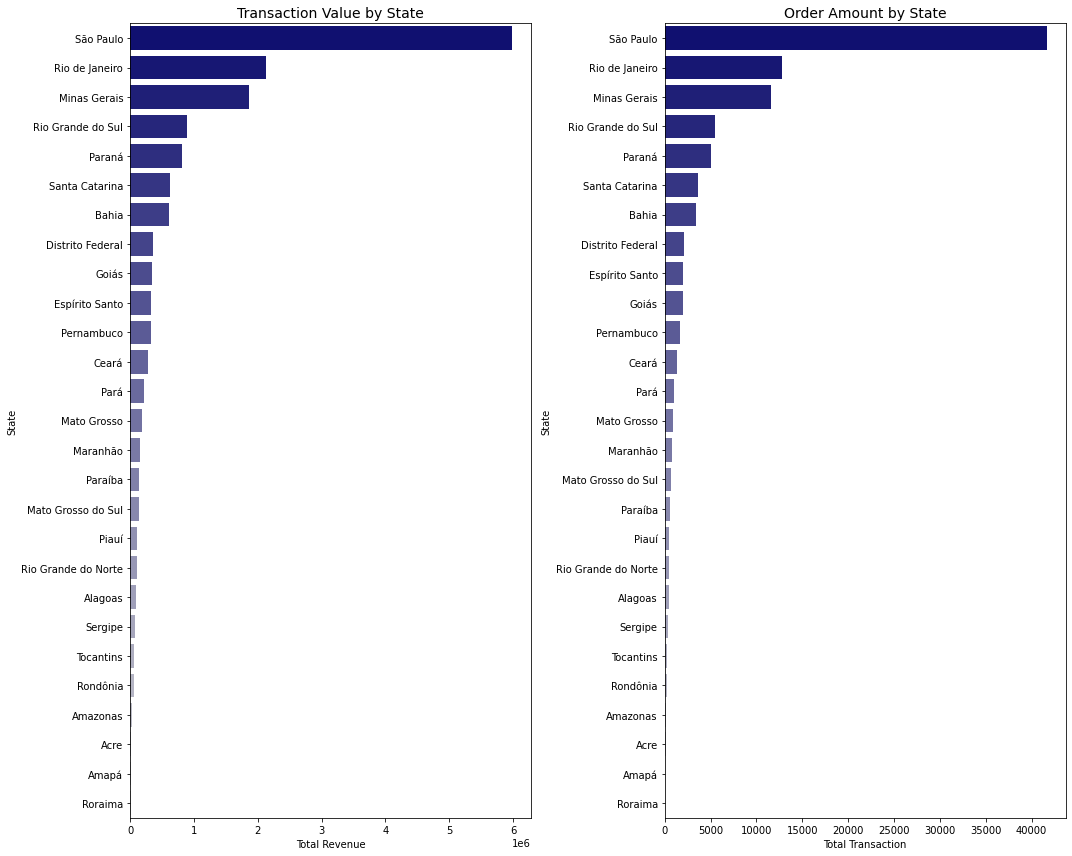

In [122]:
color_palette = sns.blend_palette(['navy', 'lightgrey'], 27)

fig, axes = plt.subplots(1, 2, figsize=(15,12))

ax1 = sns.barplot(data=state_revenue, y='customer_state_full', x='payment_value', ax=axes[0], palette=color_palette)
ax1.set_ylabel('State')
ax1.set_xlabel('Total Revenue')
ax1.set_title('Transaction Value by State',fontsize=14)

ax2 = sns.barplot(data=state_transaction, y='customer_state_full', x='order_id', ax=axes[1], palette=color_palette)
ax2.set_ylabel('State')
ax2.set_xlabel('Total Transaction')
ax2.set_title('Order Amount by State',fontsize=14)

plt.tight_layout()
plt.show()

> - Terlihat bahwa State dengan transaksi dan pendapatan tertinggi adalah Sao Paulo, Rio de Janeiro, Minas Gerais, Rio Grande do Sul, dan Parana.

#### 3.2.5 By Time

`Median Waktu yang Dibutuhkan untuk Menyelesaikan Satu Order`

In [123]:
# Membuat dataframe yang berisi informasi datetime dikelompokkan berdasarkan order_id
df_time = clean_dataset[['order_id', 'month_year_order', 'seller_id', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
          'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp', 'week_order']].groupby('order_id').max().reset_index()

# Menghitung waktu yang dibutuhkan dari satu proses ke proses selanjutnya dalam satuan hari
df_time['purchase_to_approve'] = (df_time['order_approved_at'] - df_time['order_purchase_timestamp']) / np.timedelta64(1, 'D')
df_time['approve_to_carrier'] = (df_time['order_delivered_carrier_date'] - df_time['order_approved_at']) / np.timedelta64(1, 'D')
df_time['carrier_to_customer'] = (df_time['order_delivered_customer_date'] - df_time['order_delivered_carrier_date']) / np.timedelta64(1, 'D')
df_time['customer_to_review_creation'] = (df_time['review_creation_date'] - df_time['order_delivered_customer_date']) / np.timedelta64(1, 'D')
df_time['review_creation_to_answer'] = (df_time['review_answer_timestamp'] - df_time['review_creation_date']) / np.timedelta64(1, 'D')

# Menghitung durasi waktu estimasi
df_time['estimate_approve_to_carrier'] = (df_time['shipping_limit_date'] - df_time['order_approved_at']) / np.timedelta64(1, 'D')
df_time['estimate_carrier_to_customer'] = (df_time['order_estimated_delivery_date'] - df_time['shipping_limit_date']) / np.timedelta64(1, 'D')

# Membuat label informasi
df_time['seller_info'] = np.where((df_time['order_delivered_carrier_date'] > df_time['shipping_limit_date']), 'late', 'early/on time')
df_time['delivery_info'] = np.where((df_time['order_delivered_customer_date'] > df_time['order_estimated_delivery_date'] + datetime.timedelta(days=1)), 'late', 'early/on time') 

# 'order_estimated_delivery_time' kita tambah 1 karena diasumsikan delivered date berlaku hingga pukul 23:59:59 bukan 00:00:00

In [124]:
# Mendapatkan kolom dengan tipe numerikal pada dataset df_time
numerical_cols_in_df_time = df_time.describe(include=[np.number]).columns

# Membuat tabel berisi informasi distribusi data

list_pvalue = []
list_distribution = []

for i, j in enumerate(numerical_cols_in_df_time) :

     pvalue=normaltest(df_time[j])[1]
     list_pvalue.append(pvalue)
     if pvalue > 0.05 :
        list_distribution.append('Data terdistribusi normal')
     else :
        list_distribution.append('Data tidak terdistribusi normal')

df_time_distribution = pd.DataFrame(
   data = { 'pvalue' : list_pvalue,
            'distribution' : list_distribution},
   index = numerical_cols_in_df_time)

df_time_distribution

,pvalue,distribution
purchase_to_approve,0.0,Data tidak terdistribusi normal
approve_to_carrier,0.0,Data tidak terdistribusi normal
carrier_to_customer,0.0,Data tidak terdistribusi normal
customer_to_review_creation,0.0,Data tidak terdistribusi normal
review_creation_to_answer,0.0,Data tidak terdistribusi normal
estimate_approve_to_carrier,0.0,Data tidak terdistribusi normal
estimate_carrier_to_customer,0.0,Data tidak terdistribusi normal


Karena data tidak terdistibusi normal, maka kita akan gunakan median untuk mengetahui lamanya waktu dari setiap proses

In [125]:
# Membuat table yang berisi informasi median waktu dari setiap proses
df_process_median = df_time.describe(include=[np.number]).round(2) \
    .transpose().reset_index()\
    .rename(columns={'index':'process','50%':'median'}).loc[0:4,['process','median']]

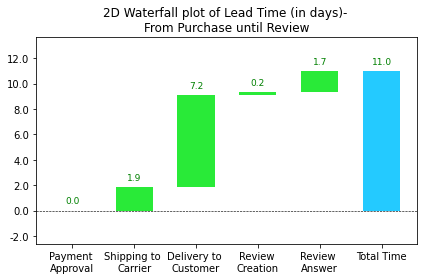

In [126]:
#Visualization
x1,y1=df_process_median['process'],df_process_median['median']
waterfall.plot(x1, y1,)
plt.xticks(range(0,6),labels=['Payment \nApproval', 'Shipping to \nCarrier', 'Delivery to \nCustomer', 
                              'Review \nCreation', 'Review \nAnswer', 'Total Time'], rotation=0)
plt.title("2D Waterfall plot of Lead Time (in days)- \nFrom Purchase until Review")
plt.tight_layout()
plt.show()

> Terlihat bahwa median waktu proses dari awal pembelian hingga submit review berada di angka 11 hari dengan rincian :
> - Median waktu dari pembelian hingga proses persetujuan pembayaran adalah 0.01 hari atau sekitar 15 menit.
> - Median waktu untuk pengepakan dari seller hingga pengiriman ke kurir adalah 1.9 hari.
> - Median waktu untuk pengiriman oleh kurir ke customer adalah 7.2 hari.
> - Survey kepuasan pelanggan dikirim sekitar 0.2 hari atau 5 jam setelah paket diterima.
> - Median waktu yang dibutuhkan customer untuk memberikan jawaban atas survey kepuasan pelanggan adalah 1.7 hari.


`Persentase Keterlambatan Shipping dan Delivery Tiap Bulan`

In [127]:
# Membuat dataframe untuk menentukan persentase keterlambatan delivery pada tiap bulan
df_delivery = df_time.pivot_table(
    index = 'month_year_order',
    columns = 'delivery_info', 
    values = 'order_id', 
    aggfunc= len
).reset_index()

df_delivery['percentage_late_delivery'] = round((df_delivery['late'] / (df_delivery['late'] + df_delivery['early/on time'])) * 100, 2)
df_delivery['month_year_order'] = df_delivery['month_year_order'].dt.strftime('%Y-%m')

# Menghitung average order value untuk periode Januari 2017 - September 2018

average_late_delivery = round((df_delivery['late'].sum() / (df_delivery['late'].sum() + df_delivery['early/on time'].sum())) * 100,1)
average_late_delivery

6.8

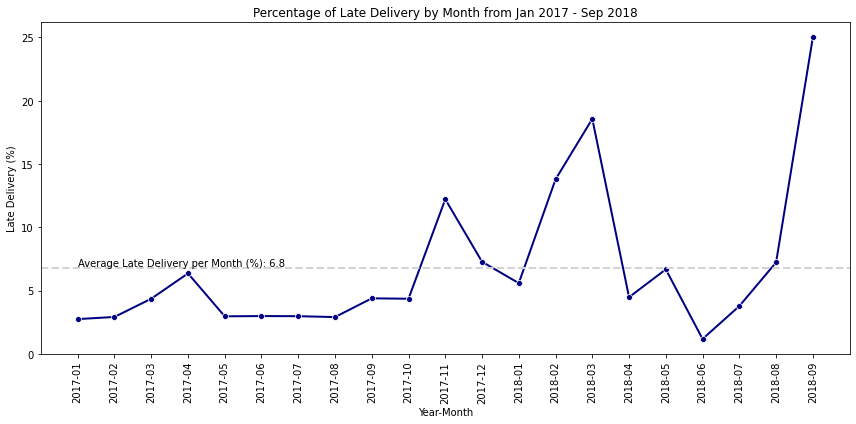

In [128]:
# Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=df_delivery, x='month_year_order', y='percentage_late_delivery', linewidth=2, color='navy', marker='o')
plt.axhline(average_late_delivery, color='lightgrey', linestyle='--', linewidth=2)
plt.title('Percentage of Late Delivery by Month from Jan 2017 - Sep 2018')
plt.text(0, average_late_delivery * 1.02, f'Average Late Delivery per Month (%): {average_late_delivery:0.1f}')
plt.xticks(rotation=90)
plt.ylabel('Late Delivery (%)')
plt.xlabel('Year-Month')

plt.tight_layout()
plt.show()


>- Rata-rata keterlambatan delivery tiap bulannya berkisar di angka 6.8%.
>- Tingkat keterlambatan di tahun 2017 relatif berada di bawah rata-rata, sedangkan pada tahun 2018 tingkat keterlambatan cenderung meningkat dengan puncaknya pada bulan Maret 2018.

In [129]:
# Membuat dataframe untuk menentukan persentase keterlambatan shipping oleh seller pada tiap bulan
df_shipping = df_time.pivot_table(
    index = 'month_year_order',
    columns = 'seller_info', 
    values = 'order_id', 
    aggfunc= len
).reset_index()

df_shipping['percentage_late_shipping'] = round((df_shipping['late'] / (df_shipping['late'] + df_shipping['early/on time'])) * 100, 2)
df_shipping['month_year_order'] = df_shipping['month_year_order'].dt.strftime('%Y-%m')

# Menghitung average order value untuk periode Januari 2017 - September 2018

average_late_shipping = round((df_shipping['late'].sum() / (df_shipping['late'].sum() + df_shipping['early/on time'].sum())) * 100,1)
average_late_shipping

8.8

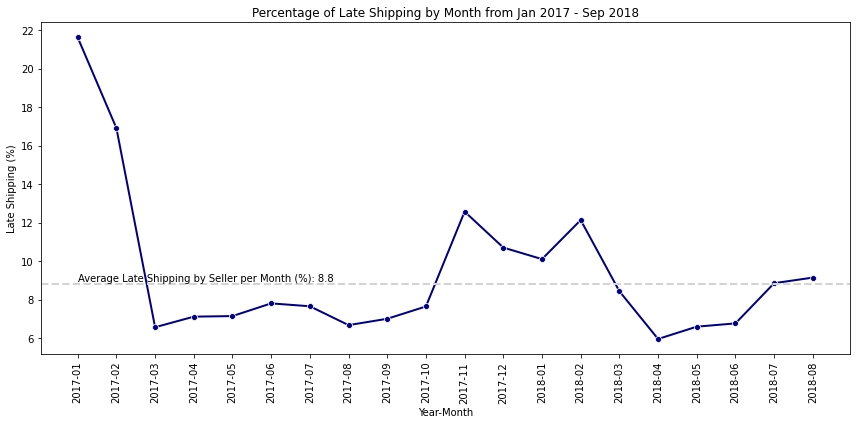

In [130]:
# Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=df_shipping, x='month_year_order', y='percentage_late_shipping', linewidth=2, color='navy', marker='o')
plt.axhline(average_late_shipping, color='lightgrey', linestyle='--', linewidth=2)
plt.title('Percentage of Late Shipping by Month from Jan 2017 - Sep 2018')
plt.text(0, average_late_shipping * 1.02, f'Average Late Shipping by Seller per Month (%): {average_late_shipping:0.1f}')
plt.xticks(rotation=90)
plt.ylabel('Late Shipping (%)')
plt.xlabel('Year-Month')

plt.tight_layout()
plt.show()

> - Rata-rata keterlambatan shipping oleh seller tiap bulannya berkisar di angka 8.8%.
> - Tingkat keterlambatan tertinggi di tahun 2017 terjadi pada bulan Januari dan Februari kemudian berangsur turun  di bawah rata-rata sebelum meningkat kembali di bulan November dan Desember. 
> - Sedangkan pada tahun 2018 tingkat keterlambatan cenderung tinggi di bulan Januari dan Februari kemudian berangsur turun di bawah rata-rata.
> - Jika diperhatikan tingkat keterlambatan shipping oleh seller cenderung tinggi pada awal dan akhir tahun yaitu di bulan November, Desember, Januari, dan Februari. 

In [131]:
# Membuat dataframe untuk menentukan seller yang yang sering terlambat melakukan shipping
df_seller_info = df_time.pivot_table(
    index = 'seller_id',
    columns = 'seller_info', 
    values = 'order_id', 
    aggfunc= len
).reset_index().fillna(0)

df_seller_info['total_order'] = df_seller_info['early/on time'] + df_seller_info['late']
df_seller_info['late_percentage'] = round(df_seller_info['late'] * 100.0 / df_seller_info['total_order'],2)

df_seller_info = df_seller_info.sort_values('late_percentage', ascending=False)


In [132]:
# rata-rata order per seller
df_seller_info['total_order'].mean()

32.36708033964729

In [133]:
# membuat table berisi informasi top 10 seller yang sering terlambat dengan jumlah order di atas 32

top_10_late_seller = df_seller_info[df_seller_info['total_order'] > 32].head(10)
top_10_late_seller

seller_info,seller_id,early/on time,late,total_order,late_percentage
1599,835f0f7810c76831d6c7d24c7a646d4d,12.0,31.0,43.0,72.09
2021,a7f13822ceb966b076af67121f87b063,30.0,39.0,69.0,56.52
1986,a49928bcdf77c55c6d6e05e09a9b4ca5,43.0,54.0,97.0,55.67
1019,54965bbe3e4f07ae045b90b0b8541f52,36.0,41.0,77.0,53.25
329,1ca7077d890b907f89be8c954a02686a,53.0,60.0,113.0,53.10
347,1da366cade6d8276e7d8beea7af5d4bf,21.0,21.0,42.0,50.00
1654,88460e8ebdecbfecb5f9601833981930,120.0,117.0,237.0,49.37
2622,db2956745b3a8e9f3785c99f34b5d25e,24.0,23.0,47.0,48.94
1848,99002261c568a84cce14d43fcffb43ea,18.0,17.0,35.0,48.57
1598,834f8533b2ecb6598dd004ff3de7203a,23.0,20.0,43.0,46.51


> - Terlihat pada tabel di atas 10 id seller yang sering melakukan keterlambatan shipping

`Pengaruh Keterlambatan Shipping terhadap Delivery`

In [134]:
# Membuat dataframe untuk menentukan persentase keterlambatan delivery pada tiap bulan
df_shipping_and_delivery = df_time.pivot_table(
    index = 'seller_info',
    columns = 'delivery_info', 
    values = 'order_id', 
    aggfunc= len
)

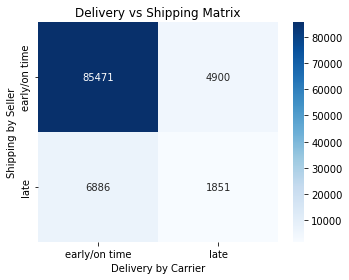

In [135]:
# Visualization
plt.figure(figsize=(5,4))
sns.heatmap(df_shipping_and_delivery,annot=True,fmt="d",cmap='Blues')
plt.xlabel("Delivery by Carrier")
plt.ylabel("Shipping by Seller")
plt.title("Delivery vs Shipping Matrix",size=12)

plt.tight_layout()
plt.show()

> Berdasarkan matrix di atas terlihat bahwa :
> - Jumlah pesanan yang tiba tepat waktu di customer ada sebanyak 85471 + 6886 = 92357 pesanan (93.19%)
> - Jumlah pesanan yang tiba terlambat di customer ada sebanyak 4900 + 1851 = 6751 pesanan (6.81%)
> - Dari seluruh pesanan yang tiba terlambat, 4900 (72.6%) - nya dikarenakan pengiriman sedangkan 1851 (27.4%) terkena dampak dari keterlambatan seller.
> - Ada sebanyak 6886 pesanan yang terlambat dikirimkan oleh seller ke perusahaan ekspedisi, namun tetap sampai dengan tepat waktu ke customer.
> - 85471/(85471+4900) = 94.6% pesanan akan tiba dengan tepat waktu di customer apabila seller mengirim tepat waktu ke perusahaan ekspedisi. 
> - 4900/99108 = 4.9% pesanan dari seluruh transaksi tiba terlambat di customer murni karena kesalahan perusahaan ekspedisi.
> - Apabila seller mengirim tepat waktu, maka potensi keterlambatan hanya 4900/(85471+4900) = 5.4% sedangkan jika seller terlambat maka peluangya naik menjadi 1851/(1851+6886) = 21.2%. Maka seller harus mengirim tepat waktu.

`Komparasi Antara Estimasi dan Aktual Waktu Delivery`

In [136]:
# Membuat dataframe yang berisi perbandingan antara waktu aktual dan waktu estimasi dari pengiriman barang
df_actual_vs_estimation_delivery = df_time.groupby('month_year_order').median()[['carrier_to_customer', 'estimate_carrier_to_customer']].round(2).reset_index()
df_actual_vs_estimation_delivery['month_year_order'] = df_actual_vs_estimation_delivery['month_year_order'].dt.strftime('%Y-%m')
df_actual_vs_estimation_delivery['margin'] = df_actual_vs_estimation_delivery['estimate_carrier_to_customer'] - df_actual_vs_estimation_delivery['carrier_to_customer']

In [137]:
list_margin = df_actual_vs_estimation_delivery['margin']
list_estimate = df_actual_vs_estimation_delivery['estimate_carrier_to_customer']
list_symbol = ['+' if x >= 0 else '' for x in list_margin]

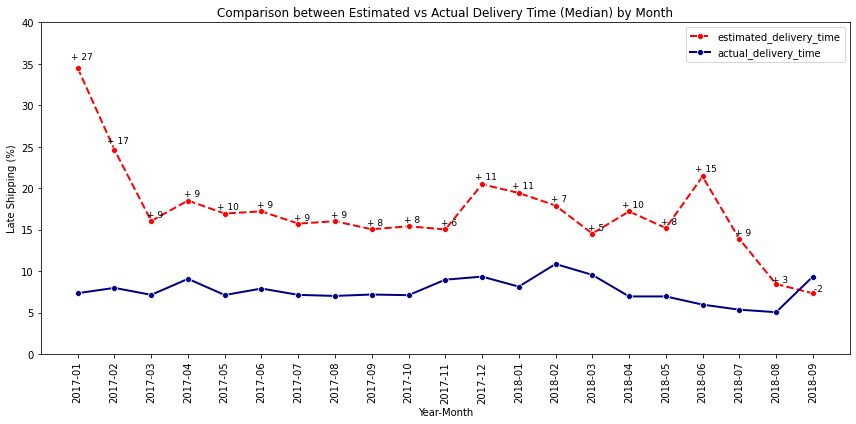

In [138]:
# Visualization
plt.figure(figsize=(12,6))

lineplot_estimate = sns.lineplot(data=df_actual_vs_estimation_delivery, x='month_year_order', y='estimate_carrier_to_customer', linestyle='--', linewidth=2, color='red', marker='o', label='estimated_delivery_time')
lineplot_actual = sns.lineplot(data=df_actual_vs_estimation_delivery, x='month_year_order', y='carrier_to_customer', linewidth=2, color='navy', marker='o', label='actual_delivery_time')

### menambahkan label data
for xtick in lineplot_estimate.get_xticks():
    lineplot_estimate.text(xtick + 0.1, list_estimate[xtick] * 1.03, f'{list_symbol[xtick]} {list_margin[xtick]:,.0f}', 
            horizontalalignment='center',size=9 ,color='black')

plt.title('Comparison between Estimated vs Actual Delivery Time (Median) by Month')
plt.xticks(rotation=90)
plt.yticks(range(0,45,5))
plt.ylabel('Late Shipping (%)')
plt.xlabel('Year-Month')
plt.legend

plt.tight_layout()
plt.show()

> Secara umum, barang diterima lebih cepat dibandingkan waktu yang diperkirakan.\
> Hal ini cukup baik dari sisi pengiriman, namun jika diperhatikan lebih lanjut terdapat gap yang cukup lebar antara estimasi waktu delivery dengan aktualnya dengan rentang antara 3 - 27 hari.\
> Hal ini tentunya perlu menjadi perhatian dikhawatirkan customer menjadi enggan untuk melakukan pembelian dikarenakan estimasi waktu delivery yang terlalu lama.

`Dampak Keterlambatan Terhadap Hasil Review`

In [139]:
# menambahkan kolom 'late_delivery' pada dataframe df_time
df_time['late_delivery'] = df_time['delivery_info'].apply(lambda x : 1 if x == 'late' else 0)

# membuat dataframe berisi informasi jumlah order dan jumlah keterlambatan per minggu
df_time_weekly = df_time.groupby(['week_order'], as_index=False).agg(
    number_of_order = ('order_id', 'nunique'),
    number_of_late_delivery = ('late_delivery', 'sum')
)

# membuat dataframe berisi informasi rating rata-rata per minggu
df_review_weekly = df_payment.groupby(['week_order'], as_index=False).agg(
    avg_review_score = ('review_score', 'mean')
).round(2)

# menggabung informasi delivery dan rating per minggu
df_delivery_and_rating = df_time_weekly.merge(df_review_weekly, on='week_order', how='left')
df_delivery_and_rating['week_order'] = df_delivery_and_rating['week_order'].dt.strftime('%d-%b-%y')
df_delivery_and_rating.head()

,week_order,number_of_order,number_of_late_delivery,avg_review_score
0,08-Jan-17,46,1,4.56
1,15-Jan-17,80,4,3.92
2,22-Jan-17,197,2,4.09
3,29-Jan-17,354,9,4.12
4,05-Feb-17,467,15,4.08


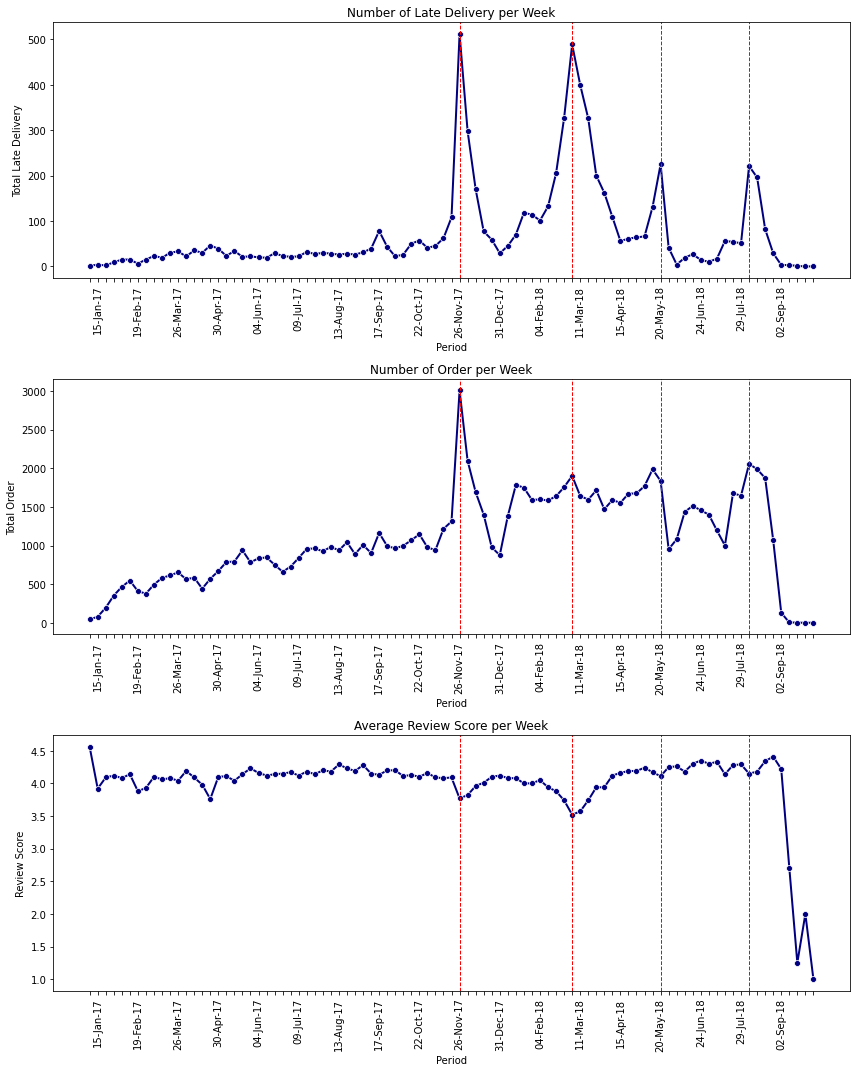

In [140]:
names = list(df_delivery_and_rating['week_order'])

new_names=[]
for n, i in enumerate(names):
    if n % 5==1:
        new_names.append(i)
    else:
        new_names.append('')

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(12,15))

ax1 = sns.lineplot(data=df_delivery_and_rating, x='week_order', y='number_of_late_delivery', linewidth=2, ax=axes[0], color='navy', marker='o')
ax1.set_title('Number of Late Delivery per Week')
ax1.set_xticks(range(0,len(df_delivery_and_rating)))
ax1.set_xticklabels(new_names, rotation=90)
ax1.axvline('26-Nov-17', color='r', linestyle='--', lw=1)
ax1.axvline('04-Mar-18', color='r', linestyle='--', lw=1)
ax1.axvline('20-May-18', color='r', linestyle='--', lw=1)
ax1.axvline('05-Aug-18', color='r', linestyle='--', lw=1)
ax1.set_ylabel('Total Late Delivery')
ax1.set_xlabel('Period')

ax2 = sns.lineplot(data=df_delivery_and_rating, x='week_order', y='number_of_order', linewidth=2, ax=axes[1], color='navy', marker='o')
ax2.set_title('Number of Order per Week')
ax2.set_xticks(range(0,len(df_delivery_and_rating)))
ax2.set_xticklabels(new_names, rotation=90)
ax2.axvline('26-Nov-17', color='r', linestyle='--', lw=1)
ax2.axvline('04-Mar-18', color='r', linestyle='--', lw=1)
ax2.axvline('20-May-18', color='r', linestyle='--', lw=1)
ax2.axvline('05-Aug-18', color='r', linestyle='--', lw=1)
ax2.set_ylabel('Total Order')
ax2.set_xlabel('Period')

ax3 = sns.lineplot(data=df_delivery_and_rating, x='week_order', y='avg_review_score', linewidth=2, ax=axes[2], color='navy', marker='o')
ax3.set_title('Average Review Score per Week')
ax3.set_xticks(range(0,len(df_delivery_and_rating)))
ax3.set_xticklabels(new_names, rotation=90)
ax3.axvline('26-Nov-17', color='r', linestyle='--', lw=1)
ax3.axvline('04-Mar-18', color='r', linestyle='--', lw=1)
ax3.axvline('20-May-18', color='r', linestyle='--', lw=1)
ax3.axvline('05-Aug-18', color='r', linestyle='--', lw=1)
ax3.set_ylabel('Review Score')
ax3.set_xlabel('Period')

plt.tight_layout()
plt.show()

> - Terlihat bahwa jumlah late delivery tertinggi terjadi pada periode minggu '26-Nov-17', '04-Mar-18', '20-May-18' dan '05-Aug-18'.
> - Jika diperhatikan, tingginya keterlambatan memiliki kaitan dengan banyaknya jumlah order di minggu tersebut 
> - Sehingga tampak bahwa perusahaan tidak mampu menangani persoalan pengiriman barang ketika permintaan sedang memuncak.
> - Dampaknya terlihat dari review score yang relatif lebih rendah pada periode tersebut

### 3.3 Customer Satisfation

#### 3.3.1 Customer Review

In [141]:
# Membuat dataframe berisi rating terbaru untuk tiap order id
df_rating = clean_dataset[['order_id', 'review_answer_timestamp', 'review_score']].sort_values(['review_answer_timestamp', 'order_id'], ascending=[False, False]).drop_duplicates(subset='order_id')

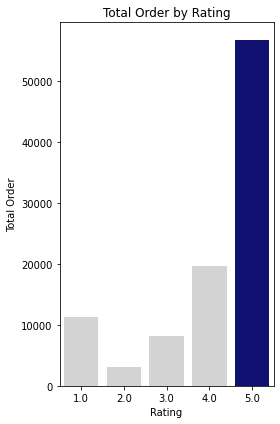

'Rating rata-rata sebesar 4.09'

In [142]:
color_palette = ['lightgrey'] * 4 + ['navy']

# Visualization
plt.figure(figsize=(4,6))
sns.countplot(data=df_rating, x='review_score', palette=color_palette)
plt.title('Total Order by Rating')
plt.ylabel('Total Order')
plt.xlabel('Rating')

plt.tight_layout()
plt.show()

display(f"Rating rata-rata sebesar {df_rating['review_score'].mean():.2f}")

>- Rating rata-rata sebesar 4.09
>- Rating dengan jumlah paling banyak adalah adalah 5.
>- Rating dengan jumlah paling sedikit adalah 2.
>- Namun rating 1 pun cukup tinggi, lebih tinggi dibandingkan rating 2 dan 3.
>- Hal ini menunjukkan bahwa customer relatif puas dengan pelayanan perusahaan saat ini, namun customer tidak segan memberikan review yang sangat buruk (poin 1) jika terdapat pelayanan yang tidak memuaskan.

In [143]:
# mengambil informasi delivery (late atau early/on time) untuk tiap order
df_delivery_info = df_time[['order_id','delivery_info']]

# menggabung rating dengan informasi delivery
df_rating_by_delivery = df_rating.merge(df_delivery_info, on='order_id', how='left')

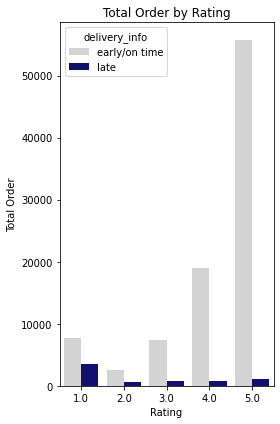

In [144]:
# Visualization
plt.figure(figsize=(4,6))
sns.countplot(data=df_rating_by_delivery, x = 'review_score', hue='delivery_info', palette=['lightgrey','navy'])
plt.title('Total Order by Rating')
plt.ylabel('Total Order')
plt.xlabel('Rating')

plt.tight_layout()
plt.show()

> - Terlihat bahwa jika deliverynya terlambat, customer cenderung untuk memberikan rating 1.
> - Sehingga perusahaan harus memastikan agar delivery pesanan tidak terlambat dengan cara :
> - 1. Memberikan poin penalti akibat pesanan yang terlambat dikirim baik kepada seller ataupun pihak delivery sesuai dengan porsi kesalahannya.
> - 2. Memberikan reward atau penghargaan kepada seller yang selalu mengirim ke perusahaan ekspedisi tepat waktu sebelum shipping_limit_date.
> - 3. Memberikan apresiasi (misal dalam bentuk rekomendasi) kepada perusahaan ekspedisi yang selalu mengirim tepat waktu ke customer bahkan disaat seller terlambat mengirim ke ekpedisi.

In [145]:
# Membuat dataframe untuk menentukan pengaruh keterlambatan
df_pivot_rating = df_rating_by_delivery.pivot_table(
    index = 'review_score',
    columns = 'delivery_info', 
    values = 'order_id', 
    aggfunc= len
).reset_index()

df_pivot_rating['% late to total order by review'] = round(df_pivot_rating['late'] * 100.0 /(df_pivot_rating['late'] + df_pivot_rating['early/on time']), 2)
df_pivot_rating['% late to total number of late'] = round(df_pivot_rating['late'] * 100.0 / df_pivot_rating['late'].sum(),2)
df_pivot_rating

delivery_info,review_score,early/on time,late,% late to total order by review,% late to total number of late
0,1.0,7703,3569,31.66,52.87
1,2.0,2548,574,18.39,8.50
2,3.0,7396,715,8.82,10.59
3,4.0,18933,817,4.14,12.10
4,5.0,55777,1076,1.89,15.94


> - Terlihat bahwa 31.66% rating 1 pada perusahaan dikarenakan oleh terlambat datangnya barang yang telah dipesan.
> - Terdapat kemungkinan sebesar 52.87% bahwa pesanan yang datang terlambat akan diberi rating 1 oleh customer.

In [146]:
# membuat tabel yang 'order_id'-nya muncul lebih dari satu baris
df_frequent_order_id = clean_dataset[clean_dataset.duplicated(subset=['order_id'], keep=False)][['order_id','review_score', 'review_answer_timestamp', 'review_comment_message']].sort_values(['order_id','review_score', 'review_answer_timestamp', 'review_comment_message'])
df_frequent_order_id

# menghilangkan baris dengan 'order_id', 'review_score', dan 'review_answer_timestamp' yang sama
df_frequent_order_id = df_frequent_order_id.drop_duplicates()
df_frequent_order_id

# kembali membuat tabel yang 'order_id'-nya muncul lebih dari satu baris namun dengan 'review_score', 'review_answer_timestamp', dan 'review_comment_message' yang berbeda
simultant_rating = df_frequent_order_id[df_frequent_order_id.duplicated(subset=['order_id'], keep=False)].sort_values(['order_id', 'review_answer_timestamp'])

In [147]:
# menambah 1 kolom yang menggabungkan 'order_id' dan 'review_score' dalam bentuk tuple
simultant_rating['order_and_review'] = list(zip(simultant_rating['order_id'], simultant_rating['review_score']))

In [148]:
order_and_review = list(simultant_rating['order_and_review'])

# menggabungkan review dengan order id yang sama
from collections import defaultdict

review_by_order_id = defaultdict(list)

for order_id, review in order_and_review:
    review_by_order_id[order_id].append(review)

dict(review_by_order_id) 

# mengambil review-nya saja saja
review_before_after = list(review_by_order_id.values())


In [149]:
# membuat pasangan review pada setiap list review dalam order id yang sama
import itertools

review_pair = []

for review in review_before_after :
    for pair in itertools.combinations(review,2):
        review_pair.append(pair)

# membuat dataframe yang berisi jumlah kemunculan/frekuensi untuk masing-masing pasangan review
df_review_pair = pd.Series(review_pair).value_counts().to_frame().reset_index().rename(columns={'index' : 'review_before_after', 0 : 'number_of_occurence'})


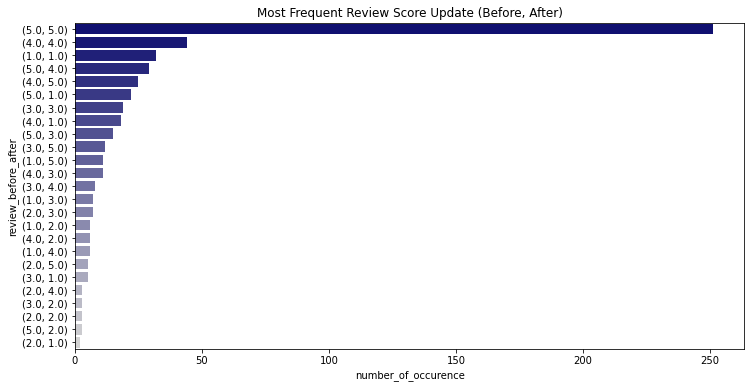

In [150]:
color_palette = sns.blend_palette(['navy', 'lightgrey'], 25)

# Visualisasi
plt.figure(figsize=(12,6))
sns.barplot(data=df_review_pair, x = 'number_of_occurence', y ='review_before_after', ci=0, order=df_review_pair['review_before_after'], palette=color_palette)
plt.title(f'Most Frequent Review Score Update (Before, After)')
plt.show()

> - Terlihat bahwa customer jarang mengubah nilai rating meskipun terdapat update review.
> - Namun perubahan rating dari 5 menjadi 1 dan dari 4 menjadi 1 cukup tinggi dan perlu menjadi perhatian perusahaan.

In [151]:
# Membandingkan nilai review sebelum dan sesudah diupdate oleh customer
df_review_pair['before'] = df_review_pair['review_before_after'].apply(lambda x : int(x[0]))
df_review_pair['after'] = df_review_pair['review_before_after'].apply(lambda x : int(x[1]))
df_review_pair['update_description'] = np.where((df_review_pair['before'] > df_review_pair['after']), 'decreasing', 
                                       np.where((df_review_pair['before'] == df_review_pair['after']), 'stable', 'increasing'))

In [152]:
# Membuat tabulasi
df_review_update = df_review_pair.groupby('update_description', as_index=False).sum()[['update_description', 'number_of_occurence']]\
                                                               .sort_values('number_of_occurence', ascending=False)

df_review_update['percentage'] = round(df_review_update['number_of_occurence'] * 100.0 / df_review_update['number_of_occurence'].sum(), 2)

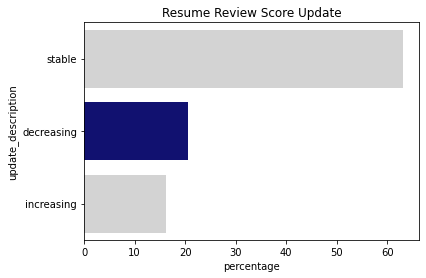

In [153]:
color_palette = sns.blend_palette(['lightgrey', 'navy', 'lightgrey'], 3)

# Visualisasi
plt.figure(figsize=(6,4))
sns.barplot(data=df_review_update, x = 'percentage', y ='update_description', ci=0, order=df_review_update['update_description'], palette=color_palette)
plt.title(f'Resume Review Score Update')
plt.show()

> - Terlihat bahwa customer cenderung untuk memberikan rating yang lebih jelek dibandingkan memberi rating yang lebih baik saat melakukan update review.

#### 3.3.2 Customer Growth

In [154]:
# menentukan maximum date
max_date = df_payment['order_purchase_timestamp'].max() + datetime.timedelta(1)

# membuat dataframe yang berisi informasi terkait aktivitas setiap customer_unique_id
df_customer = df_payment.groupby('customer_unique_id', as_index=False).agg(
    recency =  ('order_purchase_timestamp', lambda x: (max_date-x.max()).days),
    frequency = ('order_id', lambda x: x.nunique()),
    monetary =  ('payment_value', 'sum'),
    avg_spend = ('payment_value', 'mean'),
    most_payment_type = ('payment_type', lambda x: x.value_counts().index[0]),
    avg_review_score = ('review_score', 'mean'),
    most_product_buy = ('product_category_name_english', lambda x: x.value_counts().index[0]),
    first_transaction = ('month_year_order', 'min')
)

In [155]:
# membuat dataframe yang berisi informasi jumlah customer pada tiap bulan
df_new_customer = df_customer.groupby('first_transaction', as_index=False).agg({'customer_unique_id': 'count'})
df_new_customer.rename(columns = {'first_transaction':'year-month', 'customer_unique_id':'new_customer'}, inplace = True)
df_new_customer['year-month'] = df_new_customer['year-month'].dt.strftime('%Y-%m')
df_new_customer['total_customer'] = df_new_customer['new_customer'].cumsum()
df_new_customer['previous_total_customer'] = df_new_customer['total_customer'].shift(1).fillna(0)
df_new_customer['percentage_growth'] = round(df_new_customer['new_customer'] * 100.0 / df_new_customer['previous_total_customer'],2)

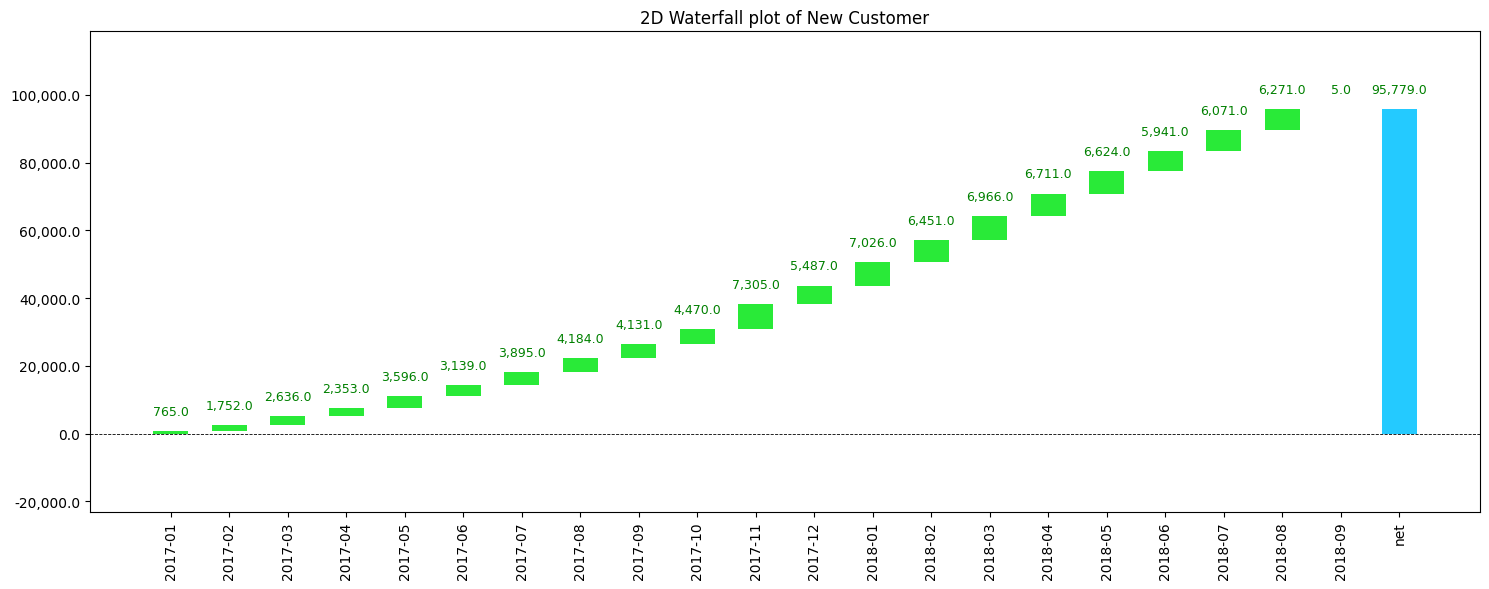

In [156]:
# Visualization
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':100})
x1,y1=df_new_customer['year-month'],df_new_customer['new_customer']
waterfall.plot(x1, y1,)
plt.xticks(rotation=90)
plt.title("2D Waterfall plot of New Customer")
plt.tight_layout()
plt.show()

> - Customer pertama didapatkan pada bulan Januari tahun 2017 bulan sebanyak 765 customer.
> - Hingga bulan September tahun 2017, jumlah customer sudah mencapai 95779 customer. 
> - Setiap bulannya selalu ada customer baru yang melakukan transaksi dengan pertumbuhan customer tertinggi terjadi pada bulan November tahun 2017 sebanyak 7035 customer.


In [157]:
list_growth = df_new_customer['percentage_growth']

posx and posy should be finite values
posx and posy should be finite values


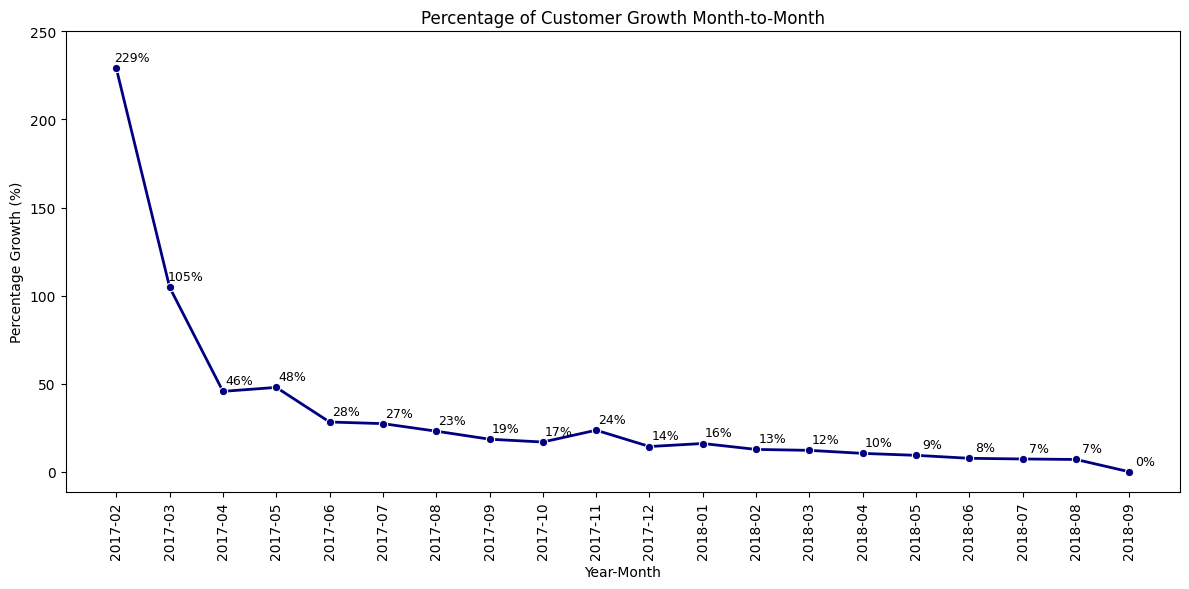

In [158]:
# Visualization
plt.figure(figsize=(12,6))
lineplot_growth = sns.lineplot(data=df_new_customer, x='year-month', y='percentage_growth', linewidth=2, color='navy', marker='o')
plt.title('Percentage of Customer Growth Month-to-Month')
plt.xticks(rotation=90)
plt.yticks(range(0,300,50))
plt.ylabel('Percentage Growth (%)')
plt.xlabel('Year-Month')

### menambahkan label data
for xtick in lineplot_growth.get_xticks():
    lineplot_growth.text(xtick + 0.3, list_growth[xtick] + 4, f'{list_growth[xtick]:,.0f}%', 
            horizontalalignment='center',size=9 ,color='black')

plt.tight_layout()
plt.show()

> - Terlihat bahwa pertumbuhan jumlah customer cenderung turun sepanjang tahun 2017 hingga 2018.
> - Pada tahun 2017, pertumbuhan customer tiap bulannya masih menyentuh double digit, namun mulai bulan Mei 2018 pertumbuhan customer berada pada single digit.

#### 3.3.3 Customer Retention

Pada bagian ini kita ingin melihat *engagement user* menggunakan cohort analysis

In [159]:
# membuat dataframe cohort yang berisi jumlah customer yang melakukan transaksaksi pada tiap bulan dikelompokkan berdasarkan transaksi pertamanya
df_payment['cohort_month'] = df_payment.groupby("customer_unique_id")['order_purchase_timestamp'].transform('min').dt.to_period('M')
df_payment['current_order_month'] = df_payment['order_purchase_timestamp'].dt.to_period('M')

df_cohort = df_payment.groupby(['cohort_month', 'current_order_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop = False)
df_cohort['period_number'] = (df_cohort['current_order_month'] - df_cohort['cohort_month']).apply(attrgetter('n'))
df_cohort.head()

,cohort_month,current_order_month,n_customers,period_number
0,2017-01,2017-01,765,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4


In [160]:
# membuat pivot table cohort
pivot_cohort_retention = df_cohort.pivot_table(index = 'cohort_month',
                                               columns = 'period_number',
                                               values = 'n_customers')

# Transform to percentage:
cohort_size = pivot_cohort_retention.iloc[:,0]
retention_percent = pivot_cohort_retention.divide(cohort_size, axis = 0)

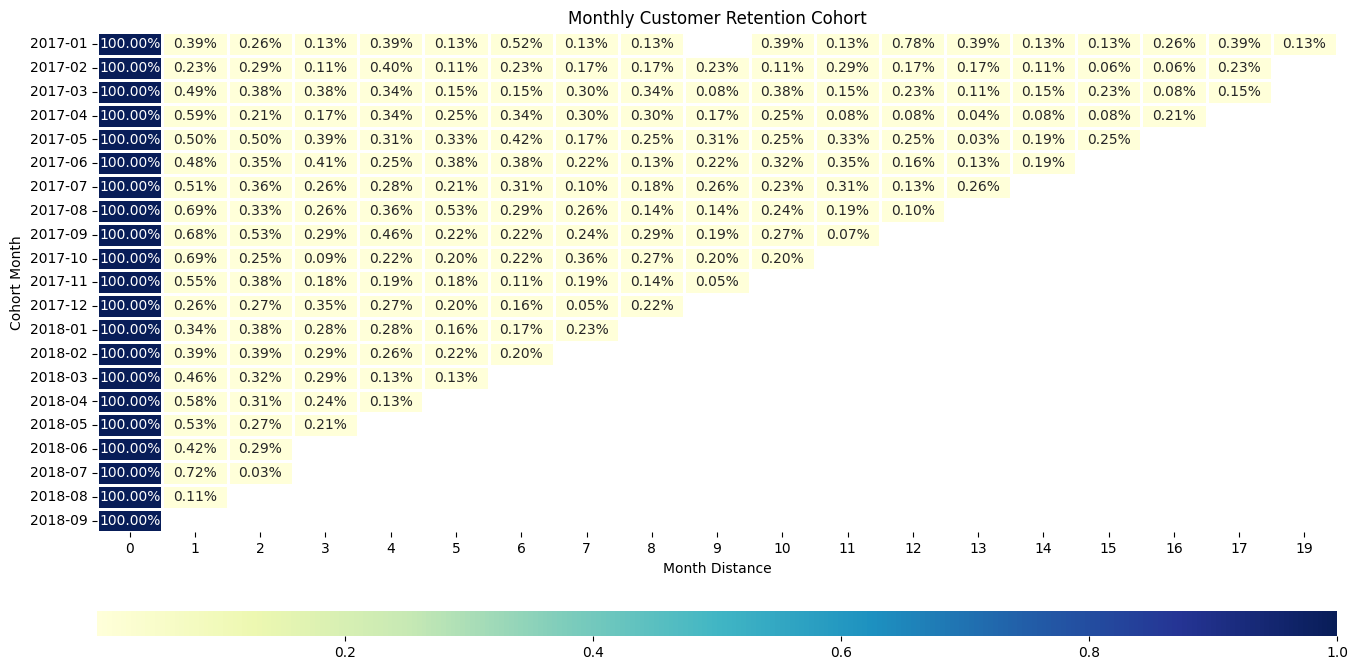

In [161]:
# mengatur ukur subplot/axes
grid_kw = {'height_ratios' : (20,1), 'hspace' : 0.3}
fig, (ax_top, ax_bottom) = plt.subplots(nrows = 2, figsize = (16,8), gridspec_kw = grid_kw)

ax_top = sns.heatmap(
    data=retention_percent,
    ax =  ax_top,                               # letak heatmap di subplot yang atas
    cbar_ax = ax_bottom,                        # letak colorbar di subplot yang bawah
    cbar_kws = {'orientation' : 'horizontal'},  # colorbar menjadi horizontal
    annot=True,                                 # memberi label nilai di dalam heatmap
    fmt = '.2%',                                # 2 digit decimal dalam persentase
    cmap='YlGnBu',                              # mengatur tema warna
    linewidths=2
    )

ax_top.set_title('Monthly Customer Retention Cohort')
ax_top.set_ylabel('Cohort Month')
ax_top.set_xlabel('Month Distance')
plt.show()

> Dari heatmap cohort analysis diatas terlihat bahwa pengguna baru yang melakukan transaksi berikutnya di bulan-bulan setelahnya tidak lebih dari 1%, yang menandakan hanya sedikit dari pengguna yang melakukan pembelian kembali

In [162]:
# menghitung jumlah customer yang melakukan transaksi lebih dari 1x
len(df_customer[df_customer['frequency']>1]) * 100.0 /len(df_customer)

3.114461416385638

> Terlihat bahwa hanya sekitar 3% pelanggan yang melakukan transaksi lebih dari 1 kali.

## 4. Area of Improvement

### 4.1 Customer Segmentation

Kita telah melihat pada analisis sebelumnya bahwa persentase customer untuk melakukan transaksi kedua dan seterusnya tidak lebih dari 1%.

Perusahaan dapat menggunakan RFM untuk mengaktifkan kembali customer yang jarang bertransaksi, membuat customer menjadi lebih loyal, serta menjadikan strategi marketing lebih efektif sehingga pada akhirnya dapat meningkatkan revenue perusahaan. 

RFM merupakan satu teknik yang dapat digunakan untuk melakukan Customer Segmentation untuk mengetahui perilaku pembelian dari customer. Arti dari RFM sendiri adalah:
- *Recency* : Waktu terakhir kali customer melakukan pembelian
- *Frequency* : Jumlah transaksi
- *Monetary* : Kekuatan belanja dari sebuah customer

Faktor pada RFM menggambarkan beberapa fakta berikut:

- Semakin baru suatu transaksi, semakin responsif seorang customer terhadap promosi
- Semakin sering customer membeli, semakin puas dan tinggi tingkat interaksi mereka 
- Nilai monetary membedakan antara  heavy spenders dengan low-value purchasers

`Recency Segmentation` 

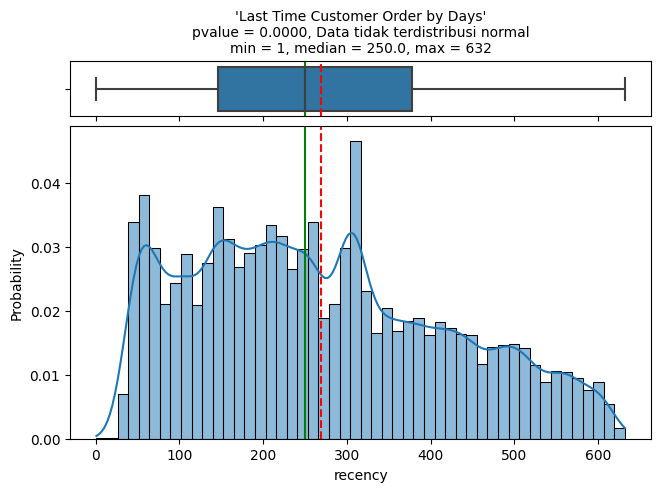

25%    146.0
50%    250.0
75%    378.0
Name: recency, dtype: float64

In [163]:
# Visualisasi 

fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (7.5,5), 
                                   gridspec_kw={"height_ratios": (.15, .85),
                                               "hspace": 0.05})

pvalue=normaltest(df_customer['recency'])[1]
if pvalue > 0.05 :
     text = (f'pvalue = {pvalue:.4f}, Data terdistribusi normal')
else :
     text = (f'pvalue = {pvalue:.4f}, Data tidak terdistribusi normal')

ax1.set_title(f"""'Last Time Customer Order by Days'
{text}
min = {df_customer['recency'].min()}, median = {df_customer['recency'].median()}, max = {df_customer['recency'].max()}""", color = "black", fontsize=10)

sns.boxplot(x = df_customer['recency'], ax = ax1)
ax1.axvline(df_customer['recency'].mean(), color='r', linestyle='--')
ax1.axvline(df_customer['recency'].median(), color='g', linestyle='-')
ax1.set(xlabel = "")
sns.histplot(data = df_customer['recency'], ax = ax2, stat = "probability", kde=True, bins=50)
ax2.axvline(df_customer['recency'].mean(), color='r', linestyle='--')
ax2.axvline(df_customer['recency'].median(), color='g', linestyle='-')
plt.show()

display(df_customer['recency'].describe()[['25%','50%','75%']])

>- Waktu terakhir customer melakukan transaksi berkisar antara 1 hari sampai 632 hari.
>- Median customer melakukan transaksi terakhir berada di angka 250 hari.
>- Q1 dan Q3 dari waktu terakhir transaksi adalah 146 hari dan 378 hari secara berturut turut.

Berdasarkan distribusi di atas, kita akan kelompokkan customer berdasarkan recency-nya ke dalam 4 kelompok yaitu :
- 4 (Active) : melakukan transaksi kurang dari 146 hari terakhir
- 3 (Warm) : melakukan transaksi antara 146 hingga 250 hari terakhir
- 2 (Cold) : melakukan transaksi antara 250 hingga 378 hari terakhir
- 1 (Inactive) : melakukan transaksi lebih dari 378 hari terakhir

In [164]:
# segmentasi Recency menggunakan quartile
label_r = range(4, 0, -1)
group_r = pd.qcut(df_customer['recency'], q=4, labels=label_r).astype('int')
df_customer['R_score'] = group_r.values

`Frequency Segmentation`

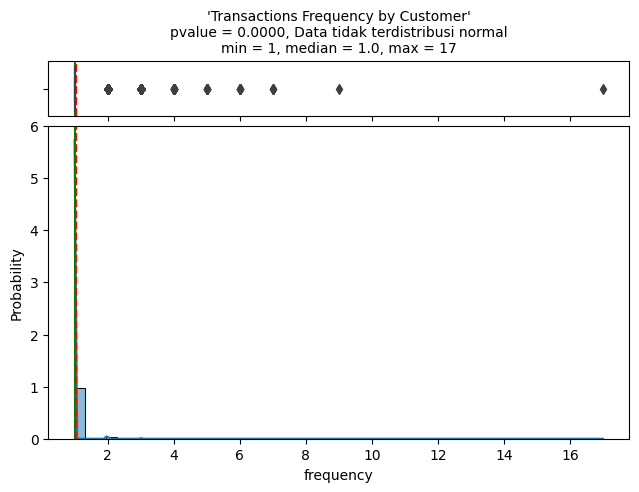

25%    1.0
50%    1.0
75%    1.0
Name: frequency, dtype: float64

In [165]:
# Visualisasi 

fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (7.5,5), 
                                   gridspec_kw={"height_ratios": (.15, .85),
                                               "hspace": 0.05})

pvalue=normaltest(df_customer['frequency'])[1]
if pvalue > 0.05 :
     text = (f'pvalue = {pvalue:.4f}, Data terdistribusi normal')
else :
     text = (f'pvalue = {pvalue:.4f}, Data tidak terdistribusi normal')

ax1.set_title(f"""'Transactions Frequency by Customer'
{text}
min = {df_customer['frequency'].min()}, median = {df_customer['frequency'].median()}, max = {df_customer['frequency'].max()}""", color = "black", fontsize=10)

sns.boxplot(x = df_customer['frequency'], ax = ax1)
ax1.axvline(df_customer['frequency'].mean(), color='r', linestyle='--')
ax1.axvline(df_customer['frequency'].median(), color='g', linestyle='-')
ax1.set(xlabel = "")
sns.histplot(data = df_customer['frequency'], ax = ax2, stat = "probability", kde=True, bins=50)
ax2.axvline(df_customer['frequency'].mean(), color='r', linestyle='--')
ax2.axvline(df_customer['frequency'].median(), color='g', linestyle='-')
plt.show()

display(df_customer['frequency'].describe()[['25%','50%','75%']])

>- Banyaknya transaksi yang dilakukan customer berkisar antara 1 sampai 17 kali.
>- Median customer melakukan transaksi berada di angka 1 kali.
>- Q1 dan Q3 dari frekuensi transaksi pun berada di angka 1 kali.
>- Hal ini menunjukkan bahwa mayoritas customer hanya melakukan transaksi sebanyak 1 kali.

Berdasarkan distribusi di atas, kita akan kelompokkan customer berdasarkan frequency-nya ke dalam 4 kelompok mengacu pada jumlah transaksi yang kita tentukan yaitu:
- 4 (Special) : melakukan transaksi minimal 4 kali
- 3 (High) : melakukan transaksi 3 kali
- 2 (Medium) : melakukan transaksi 2 kali
- 1 (Low) : melakukan transaksi hanya 1 kali.

In [166]:
# fungsi untuk menentukan F_score
def F_score(x):
    if x == 1:
        return 1
    elif x <= 2:
        return 2
    elif x <= 3:
        return 3
    else:
        return 4

df_customer['F_score'] = df_customer['frequency'].apply(F_score)
df_customer['F_score'].value_counts()


1    92796
2     2733
3      201
4       49
Name: F_score, dtype: int64

`Monetary Segmentation`

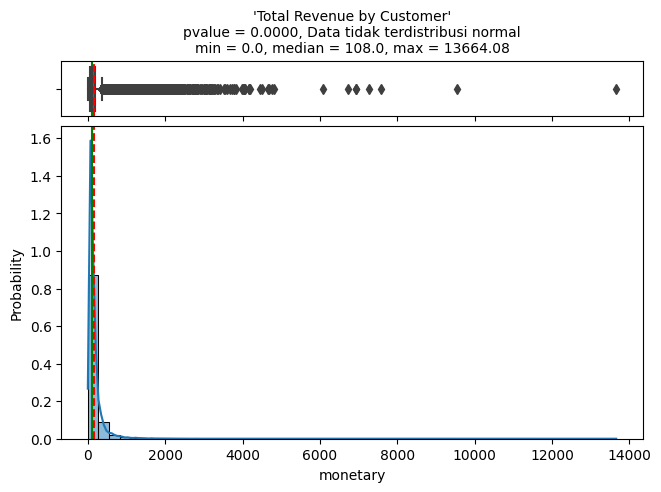

25%     63.11
50%    108.00
75%    183.45
Name: monetary, dtype: float64

In [167]:
# Visualisasi 

fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (7.5,5), 
                                   gridspec_kw={"height_ratios": (.15, .85),
                                               "hspace": 0.05})

pvalue=normaltest(df_customer['monetary'])[1]
if pvalue > 0.05 :
     text = (f'pvalue = {pvalue:.4f}, Data terdistribusi normal')
else :
     text = (f'pvalue = {pvalue:.4f}, Data tidak terdistribusi normal')

ax1.set_title(f"""'Total Revenue by Customer'
{text}
min = {df_customer['monetary'].min()}, median = {df_customer['monetary'].median()}, max = {df_customer['monetary'].max()}""", color = "black", fontsize=10)

sns.boxplot(x = df_customer['monetary'], ax = ax1)
ax1.axvline(df_customer['monetary'].mean(), color='r', linestyle='--')
ax1.axvline(df_customer['monetary'].median(), color='g', linestyle='-')
ax1.set(xlabel = "")
sns.histplot(data = df_customer['monetary'], ax = ax2, stat = "probability", kde=True, bins=50)
ax2.axvline(df_customer['monetary'].mean(), color='r', linestyle='--')
ax2.axvline(df_customer['monetary'].median(), color='g', linestyle='-')
plt.show()

display(df_customer['monetary'].describe()[['25%','50%','75%']])

>- Total pembelian customer berkisar antara 0 hingga 13664.08 Real Brasil.
>- Median total pembelian customer berada di angka 108 Real Brasil.
>- Q1 dan Q3 dari pembelian customer adalah 63.11 dan 183.45 Real Brasil secara berturut turut.

Berdasarkan distribusi di atas, kita akan kelompokkan customer berdasarkan monetary-nya ke dalam 4 kelompok yaitu :
- 4 (Top Spender) : melakukan transaksi lebih dari 183.45 Real Brasil
- 3 (High Spender) : melakukan transaksi antara 108 hingga 183.45 Real Brasil
- 2 (Mediuk Spender) : melakukan transaksi antara 63.11 hingga 108 Real Brasil
- 1 (Low Spender) : melakukan transaksi kurang dari dari 63.11 Real Brasil

In [168]:
# segmentasi Recency menggunakan quartile
label_m = range(1, 5, 1)
group_m = pd.qcut(df_customer['monetary'], q=4, labels=label_m).astype('int')
df_customer['M_score'] = group_m.values

`RFM Segmentation`

Selanjutnya kita akan menggabungan R_score, F_score, dan M_score menjadi RFM_score

In [169]:
# menentukan RFM_score
df_customer['RFM_score'] = df_customer['R_score'].astype(str) + df_customer['F_score'].astype(str) + df_customer['M_score'].astype(str)
df_customer['RFM_score'] = df_customer['RFM_score'].astype(int)

Selanjutnya kita akan mengelompokkan berdasarkan kategori berikut :

| Segment | Score |
| --- | --- | 
|Champions |443 |
|Loyal |443, 434, 344, 334 |
|Potential Loyalist |441, 442, 433, 432, 431, 423, 343, 342, 341, 333, 323 |
|New Customers |412, 411, 422, 421, 311 |
|Promising |424, 414, 413, 314, 313 |
|Need Attention |324 |
|About To Sleep |331, 321, 312, 221, 213, 231, 241 |
|At Risk |244, 243, 242, 234, 224, 143, 142, 144, 134, 133, 124 |
|Cannot Lose Them |214, 114, 113 |
|Hibernating Customers |332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211 |
|Lost Customers |111, 112, 121, 131, 141 |

In [170]:
# membuat fungsi untu segmentasi berdasarkan RFM_score
def RFM_segmentation(x):
    if x in [443] :
        return 'Champions'
    elif x in [443, 434, 344, 334] :
        return 'Loyal'
    elif x in [441, 442, 433, 432, 431, 423, 343, 342, 341, 333, 323] :
        return 'Potential Loyalist'
    elif x in [412, 411, 422, 421, 311] :
        return 'New Customers'
    elif x in [424, 414, 413, 314, 313] :
        return 'Promising'
    elif x in [324] :
        return 'Need Attention'
    elif x in [331, 321, 312, 221, 213, 231, 241] :
        return 'About To Sleep'
    elif x in [244, 243, 242, 234, 224, 143, 142, 144, 134, 133, 124] :
        return 'At Risk'
    elif x in [214, 114, 113] :
        return 'Cannot Lose Them'
    elif x in [332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211] :
        return 'Hibernating Customers'
    elif x in [111, 112, 121, 131, 141] :
        return 'Lost Customers'

In [171]:
df_customer['RFM_segment'] = df_customer['RFM_score'].apply(RFM_segmentation)

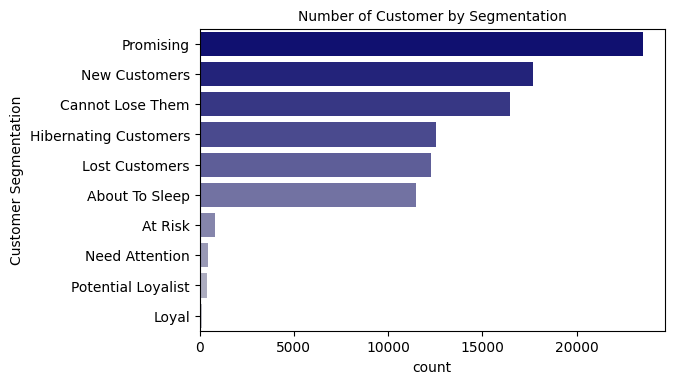

In [172]:
color_palette = sns.blend_palette(['navy', 'lightgrey'], 11)

# Visualisasi
plt.figure(figsize=(6,4))
sns.countplot(data=df_customer, y ='RFM_segment', order=df_customer['RFM_segment'].value_counts().index, palette=color_palette)
plt.title('Number of Customer by Segmentation', fontsize=10)
plt.ylabel('Customer Segmentation', fontsize=10)
plt.show()

> - Terlihat bahwa segment customer yang paling banyak adalah segmen *Promising, New Customer, Cannot Lose Them, Hibernating Customer, Lost Customers,* dan *About to Sleep*
> - Perusahaan sebaiknya melakukan pendekatan yang berbeda-beda untuk setiap segmen

In [173]:
# Segmentasi RFM untuk analisis
rfm_segment = df_customer.groupby(['RFM_segment']).agg(
    n_customer = ('customer_unique_id', 'count'),
    mean_recency =  ('recency', 'mean'),
    min_recency = ('recency', 'min'),
    max_rencency = ('recency', 'max'),
    mean_freq = ('frequency', 'mean'),
    min_freq = ('frequency', 'min'),
    max_freq = ('frequency', 'max'),
    mean_monetary =  ('monetary', 'mean'),
    min_monetary = ('monetary', 'min'),
    max_monetary = ('monetary', 'max'),
    most_payment_type = ('most_payment_type', lambda x: x.value_counts().index[0]),
    avg_review_score = ('avg_review_score', 'mean'),
    most_product_buy = ('most_product_buy', lambda x: x.value_counts().index[0]),
).sort_values(by='n_customer', ascending=False)

rfm_segment

,n_customer,mean_recency,min_recency,max_rencency,mean_freq,min_freq,max_freq,mean_monetary,min_monetary,max_monetary,most_payment_type,avg_review_score,most_product_buy
RFM_segment,,,,,,,,,,,,,
Promising,23497,141.935566,1,250,1.020641,1,2,265.762373,108.01,7274.88,credit_card,4.038279,health_beauty
New Customers,17705,125.525332,19,250,1.005535,1,2,56.697297,0.00,108.00,credit_card,4.204358,health_beauty
Cannot Lose Them,16446,425.022194,251,631,1.000000,1,1,311.002748,108.01,13664.08,credit_card,4.023349,bed_bath_table
Hibernating Customers,12560,310.944904,147,623,1.045780,1,3,66.826506,11.63,182.95,credit_card,4.098693,bed_bath_table
Lost Customers,12277,479.962043,379,632,1.001385,1,3,63.779652,10.07,108.00,credit_card,4.162580,bed_bath_table
About To Sleep,11503,253.724072,147,378,1.002086,1,2,112.819713,34.97,183.43,credit_card,3.999116,bed_bath_table
At Risk,815,379.979141,251,632,2.122699,2,6,425.655374,73.48,7571.63,credit_card,4.087413,bed_bath_table
Need Attention,448,202.138393,147,250,2.000000,2,2,384.593147,185.26,2783.01,credit_card,3.902902,bed_bath_table
Potential Loyalist,390,143.366667,30,250,2.051282,2,3,146.898795,88.27,183.26,credit_card,4.218547,bed_bath_table


| Segment | Deskripsi | Strategi |
| --- | --- | --- | 
|Champions |Membeli dalam 8 bulan terakhir dengan nilai transaksi dan frekuensi yang sangat tinggi (> 10). Cenderung untuk mempromosikan produk kita dan mengirim referral pada koleganya. |Berikan hadiah. Tawarkan produk lain dengan harga yang lebih mahal.|
|Loyal |Membeli dalam 8 bulan terakhir dengan nilai transaksi yang sangat tinggi dan frekuensi tinggi ( 3 - 9). |Berikan hadiah. Tawarkan produk lain dengan harga yang lebih mahal. |
|Promising |Membeli dalam 8 bulan terakhir dengan nilai transaksi yang tinggi namun frekuensi rendah (<= 2). |Berikan voucher. Berikan rekomendasi personal. |
|Potential Loyalist |Membeli dalam 8 bulan terakhir dengan nilai transaksi dan frekuensi yang sedang (2 - 3). |Tawarkan membership atau loyalty program. Berikan rekomendasi personal. |
|New Customers |Membeli dalam 8 bulan terakhir namun dengan nilai transaksi yang masih rendah. |Berikan dukungan pada saat proses transaksi. Mulai jalin hubungan |
|Need Attention |Membeli dalam 5-8 bulan terakhir dengan nilai transaksi yang sangat tinggi |Berikan penawaran terbatas. Berikan rekomendasi yang personal. |
|About To Sleep |Membeli dalam 5-8 bulan terakhir dengan nilai transaksi yang sedang |Berikan penawaran terbatas. |
|At Risk |Membeli lebih dari 8 bulan yang lalu dengan nilai transaksi dan frekuensi yang tinggi. |Beri bantuan saat berkunjung ke website. Kirim email yang personal. |
|Cannot Lose Them |Hanya membeli sekali lebih dari 8 bulan yang lalu namun dengan nilai transaksi yang sangat tinggi. |Dapatkan kembali, jangan sampai beralih ke kompetitor. Kontak langsung jika diperlukan. Terapkan hyper-personalization |
|Hibernating Customers |Membeli lebih dari 5 bulan yang lalu dengan nilai transaksi yang rendah. |Tumbuhkan kembali ketertarikan dengan diskon khusus pada produk tertentu. |
|Lost Customers |Membeli lebih dari 1 tahun yang lalu dengan nilai transaksi yang rendah. |Tumbuhkan kembali ketertarikan dengan campaign. Jika tidak berhasil maka abaikan. |

Secara umum dapat dilihat pada gambar berikut:

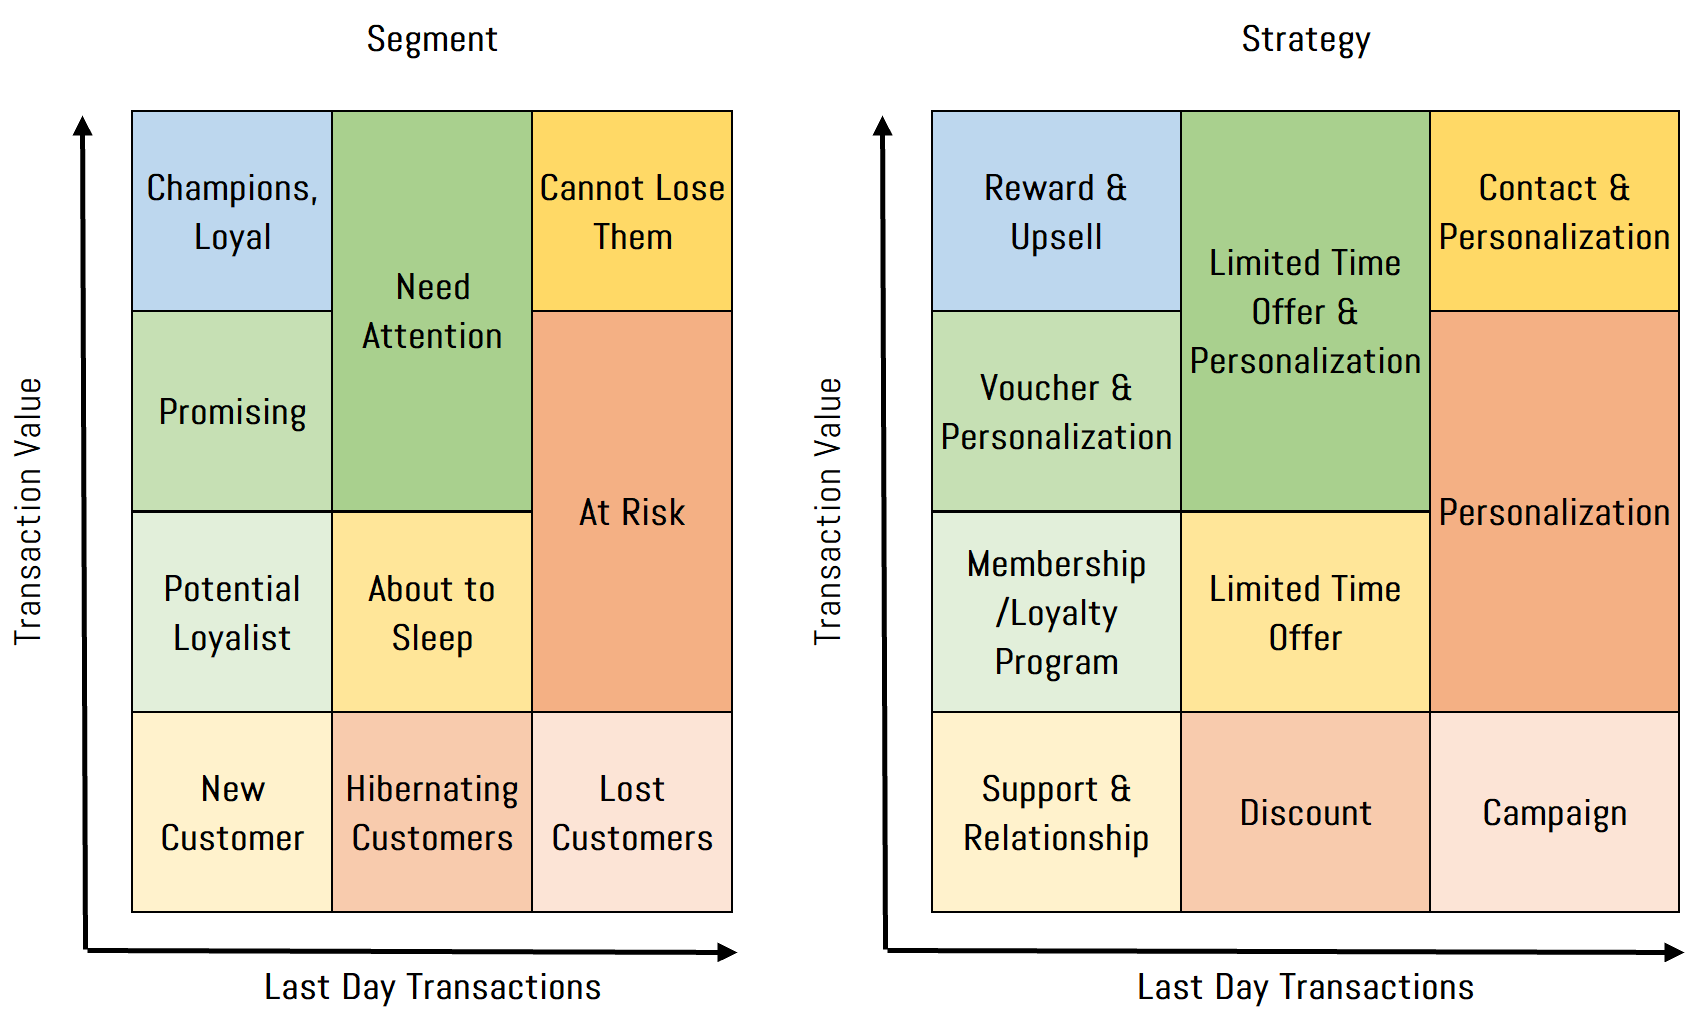

In [174]:
from IPython.display import Image
Image(filename='Segment and Strategy.png') 

### 4.2 Product Affinity Analysis

Affinity Analyisis merupakan suatu cara yang digunakan untuk menemukan pola pembelian dalam bidang ritel. Tujuannya adalah memahami perilaku konsumen dengan mengidentifikasi hubungan antara barang-barang yang dibeli agar suatu perusahaan dapat meningkatkan potensi penjualan silang (cross-selling) mereka.

Gagasan utama di balik analisis ini adalah untuk mendapatkan wawasan berharga dengan mengidentifikasi item mana yang sering dibeli bersamaan.

Pada kesempatan kali ini kita akan coba melihat kategori produk mana yang paling sering dibeli secara bersamaan.

In [175]:
# membuat tabel yang 'order_id'-nya muncul lebih dari satu baris
df_frequent_order_id = clean_dataset[clean_dataset.duplicated(subset=['order_id'], keep=False)][['order_id','product_category_name_english']].sort_values(['order_id','product_category_name_english'])

# menghilangkan baris dengan 'order_id' dan 'product_category_name_english' yang sama
df_frequent_order_id = df_frequent_order_id.drop_duplicates()

# kembali membuat tabel yang 'order_id'-nya muncul lebih dari satu baris namun dengan 'product_category_name_english' yang berbeda
simultant_product = df_frequent_order_id[df_frequent_order_id.duplicated(subset=['order_id'], keep=False)][['order_id','product_category_name_english']].sort_values(['order_id','product_category_name_english'])


In [176]:
# menambah 1 kolom yang menggabungkan 'order_id' dan 'product_category_name_english' dalam bentuk tuple
simultant_product['order_and_item'] = list(zip(simultant_product['order_id'], simultant_product['product_category_name_english']))

In [177]:
order_and_item = list(simultant_product['order_and_item'])

# menggabungkan product category dengan order id yang sama
from collections import defaultdict

item_by_order_id = defaultdict(list)

for order_id, item in order_and_item:
    item_by_order_id[order_id].append(item)

dict(item_by_order_id) 

# mengambil product category-nya saja saja
item_category = list(item_by_order_id.values())

In [178]:
# membuat pasangan product category pada setiap list product category dalam order id yang sama
import itertools

product_pair = []

for item in item_category :
    for pair in itertools.combinations(item,2):
        product_pair.append(pair)

# membuat dataframe yang berisi jumlah kemunculan/frekuensi untuk masing-masing pasangan product category
df_product_pair = pd.Series(product_pair).value_counts().to_frame().reset_index().rename(columns={'index' : 'Product Category Pair', 0 : 'Number of Occurence'})

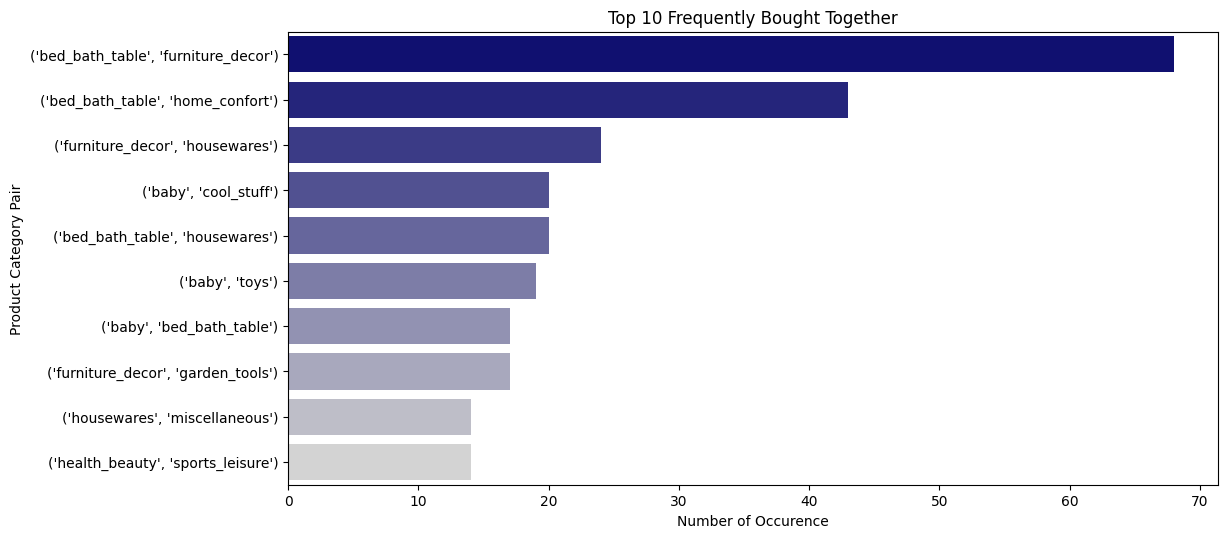

In [179]:
color_palette = sns.blend_palette(['navy', 'lightgrey'], 10)

# Visualisasi
plt.figure(figsize=(12,6))
sns.barplot(data=df_product_pair.head(10), x = 'Number of Occurence', y ='Product Category Pair', ci=0, order=df_product_pair.head(10)['Product Category Pair'], palette=color_palette)
plt.title(f'Top 10 Frequently Bought Together')
plt.xticks(range(0,80,10))
plt.show()

> - Terlihat bahwa barang-barang yang sering dibeli bersamaan adalah barang dengan kategori produk :
> - 1. *bed_bath_table* dan *furniture_decor*
> - 2. *bed_bath_table* dan *home_comfort*
> - 3. *furniture_decor* dan *housewares*
> - 4. *baby* dan *cool_stuff*
> - 5. *bed_bath_table* dan *housewares*
> - 6. *baby* dan *toys*
> - 7. *baby* dan *bed_bath_table*

> - Yang paling sering muncul adalah *bed_bath_table* dengan komplementarinya yaitu *furniture_decor*, *home_comfort*, dan *housewares* kemudian diikuti dengan *baby* bersama komplementarinya yaitu *cool_stuff*, *toys*, dan *bed_bath_table*

> - Maka sebaiknya upaya yang dapat dilakukan perusahaan untuk meningkatkan penjualan diantaranya:
> - 1. Turut menampilkan produk komplementari/pelengkap dalam sistem rekomendasinya saat customer hendak mebeli suatu produk
> - 2. Menawarkan produk yang saling melengkapi dalam bentuk bundling misal perlengkapan bayi dengan mainan

## 5. Kesimpulan

- Sebaiknya perusahaan melakukan **promosi pada jam-jam dengan aktivitas tertinggi** misal dengan cara:
- 1. Pemberian **voucher khusus & diskon** yang berlaku pada pembelian **di hari kerja**. 
- 2. Pemberian **voucher khusus & diskon** yang berlaku pada pembelian **di jam malam akhir pekan**.
- Melakukan kampanye marketing seperti **broadcast dan iklan sebelum jam 9 pagi** dimana frekuensi transaksi mulai meningkat.
- Menerapkan sistem **Fraud Detection** untuk mencegah terjadinya potensi penyalahgunaan credit card yang dapat berdampak pada hilangnya kepercayaan customer.
- Meningkatan Average Order Value dengan menerapkan strategi marketing seperti :
- 1. Mempromosikan **produk produk dengan AOV tinggi** agar produk tersebut dapat meningkat jumlah pesanannya.
- 2. Memberikan **potongan harga dengan minimal transaksi yang cukup tinggi**.
- 3. Memberikan **kemudahan dan insentif khusus** (misal bunga rendah atau 0%, free biaya admin) dalam pemberian **cicilan**.
- Memastikan agar delivery pesanan tidak terlambat dengan cara :
- 1. Memberikan **poin penalti** akibat pesanan yang **terlambat** dikirim baik kepada seller ataupun perusahaan ekspedisi sesuai dengan porsi kesalahannya.
- 2. Memberikan **reward atau penghargaan** (misal dalam bentuk rekomendasi) kepada seller dan perusahaan ekspedisi yang selalu mengirim **tepat waktu**.
- Menerapkan **customer segmentation** agar strategi pemasarannya lebih tepat sasaran.
- Turut menampilkan **produk komplementari/pelengkap** dalam sistem rekomendasinya saat customer hendak mebeli suatu produk.
- Menawarkan produk yang saling melengkapi dalam bentuk **bundling** misal perlengkapan bayi dengan mainan.
